# Data analysis

In [1]:
from collections import Counter
import pathlib
import pickle
import random
import os
import time
from typing import Any, Dict, List, Tuple

import networkx
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import qpy
from qiskit.visualization import circuit_drawer
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
import torch
import tqdm

## Auxiliary functions

In [2]:
def load_graphs(file: pathlib.Path) -> List[networkx.classes.graph.Graph]:
    with open(file, "rb") as f:
        graphs = pickle.load(f)
    return graphs


def load_circuits(file: pathlib.Path) -> List[qiskit.circuit.quantumcircuit.QuantumCircuit]:
    with open(file, "rb") as f:
        circuits = qpy.load(f)
    return circuits


def draw_networkx_graph(g: networkx.classes.graph.Graph, filename: str = "graph.png") -> None:
    # drawing in circular layout

    # Define figure size and DPI
    plt.figure(figsize=(10, 10), dpi=100)  # Adjust width and height as needed

    # Position nodes using a layout algorithm
    pos = nx.circular_layout(g)

    # Draw nodes with color and size based on metadata
    nx.draw_networkx_nodes(g, pos, node_size=500, node_color='skyblue')

    # Draw edges
    nx.draw_networkx_edges(g, pos)

    # Draw node labels
    nx.draw_networkx_labels(g, pos, labels={node: str(node) for node in g.nodes}, font_size=10, font_color="black")

    # Draw node 'mu' weights slightly below the node
    mu_labels = {node: f"{g.nodes[node]['mu']:.2f}" for node in g.nodes if "mu" in g.nodes[node]}
    pos_mu = {node: (x, y - 0.08) for node, (x, y) in pos.items()}  # shift mu label slightly down
    nx.draw_networkx_labels(g, pos_mu, labels=mu_labels, font_size=9, font_color="darkgreen")

    # Draw edge labels (weights and custom labels)
    edge_labels = {(u, v): f"({g.edges[u, v]['weight']:.2f})" for u, v in g.edges if "weight" in g.edges[u, v]}
    nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_size=9)

    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # To save the figure with the specified size:
    # plt.savefig("graph.png", dpi=100)


def repair_graph(G: nx.Graph) -> nx.Graph:
    mu = G.graph["mu"]
    weights = G.graph["weights"]

    for i, weight in enumerate(mu):
        if i in G.nodes:
            G.add_node(i)
            G.nodes[i]["mu"] = weight

    num_nodes = weights.shape[0]
    for i in range(num_nodes):
        for j in range(num_nodes):
            weight = weights[i, j]
            G.add_edge(i, j, weight=weight)

    G.graph.pop("mu", None)
    G.graph.pop("weights", None)

    return G


def graph_to_str_v1(graph: networkx.classes.graph.Graph) -> str:
    g_nodes_str = " ".join([f"{graph.nodes[u]['mu']:.2f}" for u in graph.nodes]) # 2-decimal precision
    g_edges_str = ", ".join([f"({u}, {v}), {graph.edges[u, v]['weight']:.2f}" for u, v in graph.edges]) # 2-decimal precision
    bos_token = "<bos>"
    end_of_graph_token = "<end_of_graph>"
    nodes_weight_start = "<node_weights_start>"
    nodes_weight_end = "<node_weights_end>"
    return " ".join([
        bos_token,
        "<format_v1>",
        nodes_weight_start,
        g_nodes_str,
        nodes_weight_end,
        g_edges_str,
        end_of_graph_token
    ])


def graph_to_str_v2(graph: networkx.classes.graph.Graph) -> str:
    g_nodes_str = " ".join([f"{graph.nodes[u]['mu']:.3f}" for u in graph.nodes]) # 3-decimal precision
    g_edges_str = ", ".join([f"({u}, {v}), {graph.edges[u, v]['weight']:.3f}" for u, v in graph.edges]) # 3-decimal precision
    bos_token = "<bos>"
    end_of_graph_token = "<end_of_graph>"
    nodes_weight_start = "<node_weights_start>"
    nodes_weight_end = "<node_weights_end>"
    return " ".join([
        bos_token,
        "<format_v2>",
        nodes_weight_start,
        g_nodes_str,
        nodes_weight_end,
        g_edges_str,
        end_of_graph_token
    ])


def graph_to_tokens_v1(graph: networkx.classes.graph.Graph, version_token: str = "<format_v1>") -> List[str]:
    """
        Compound tokens like '(0, 1)' and '[0 1]'.
        And 2-decimal precision for float numbers.
        Graphs with nodes and edges weights.
    """
    bos_token = "<bos>"
    end_of_graph_token = "<end_of_graph>"
    nodes_weight_start = "<node_weights_start>"
    nodes_weight_end = "<node_weights_end>"
    graph_tokens = []
    graph_tokens.append(bos_token)
    graph_tokens.append(version_token)

    # nodes
    graph_tokens.append(nodes_weight_start)
    for u in graph.nodes:
        if "return_" in graph.nodes[u]:
            graph_tokens.append(f"{graph.nodes[u]['return_']:.2f}") # 2-decimal precision
        elif "mu" in graph.nodes[u]:
            graph_tokens.append(f"{graph.nodes[u]['mu']:.2f}") # 2-decimal precision
        else:
            raise Exception(f"Cannot find return value using key 'mu' and 'return_'.")
    graph_tokens.append(nodes_weight_end)
    
    # edges
    for u, v in graph.edges:
        graph_tokens.append(f"({u},{v})")
        graph_tokens.append(f"{graph.edges[u, v]['weight']:.2f}") # 2-decimal precision
    graph_tokens.append(end_of_graph_token)    
    return graph_tokens


def graph_to_tokens_v2(graph: networkx.classes.graph.Graph) -> List[str]:
    """
        Compositional tokens like '(', '0', '1', ')'.
        And 3-decimal precision for float numbers.
        Graphs with nodes and edges weights.
    """
    bos_token = "<bos>"
    end_of_graph_token = "<end_of_graph>"
    nodes_weight_start = "<node_weights_start>"
    nodes_weight_end = "<node_weights_end>"
    graph_tokens = []
    graph_tokens.append(bos_token)
    graph_tokens.append("<format_v2>")
    
    # nodes
    graph_tokens.append(nodes_weight_start)
    for u in graph.nodes:
        graph_tokens.append(f"{graph.nodes[u]['mu']:.3f}") # 3-decimal precision
    graph_tokens.append(nodes_weight_end)
    
    # edges
    for u, v in graph.edges:
        graph_tokens.append("(")
        graph_tokens.append(f"{u}")
        graph_tokens.append(f"{v}")
        graph_tokens.append(")")
        graph_tokens.append(f"{graph.edges[u, v]['weight']:.3f}") # 3-decimal precision
    graph_tokens.append(end_of_graph_token)
    return graph_tokens


def circuit_to_str_v1(circuit: qiskit.circuit.quantumcircuit.QuantumCircuit) -> str:
    op_names_exclude = {"barrier", "h", "initialize", "measure"}

    circuit_str = ""
    for idx, instruction in enumerate(circuit.data):
        op_name = instruction.operation.name
        if op_name in op_names_exclude: # skip unnecessary operations
            continue
        params = instruction.operation.params
        params_str = "".join(map(lambda x: f"{x:.2f}", params))
        qubit_labels = [circuit.qubits.index(qubit) for qubit in instruction.qubits]
        circuit_str += f"<new_layer_p>, {op_name}, {qubit_labels}" + (f", {params_str}" if params_str else "") + " "
    
    return circuit_str


def circuit_to_str_v2(circuit: qiskit.circuit.quantumcircuit.QuantumCircuit) -> str:
    op_names_exclude = {"barrier", "h", "initialize", "measure"}

    circuit_str = ""
    for idx, instruction in enumerate(circuit.data):
        op_name = instruction.operation.name
        if op_name in op_names_exclude: # skip unnecessary operations
            continue
        params = instruction.operation.params
        params_str = "".join(map(lambda x: f"{x:.2f}", params)) # 2-decimal precision
        qubit_labels = [circuit.qubits.index(qubit) for qubit in instruction.qubits]
        qubit_labels_str = "(" + ", ".join(map(str, qubit_labels)) + ")"
        circuit_str += f"<new_layer_p>, {op_name}, {qubit_labels_str}" + (f", {params_str}" if params_str else "") + " "
    
    return circuit_str


def circuit_to_tokens_v1(circuit: qiskit.circuit.quantumcircuit.QuantumCircuit) -> List[str]:
    """
        Compound tokens like '(0, 1)' and '[0 1]'.
        And 2-decimal precision for float numbers.
    """
    op_names_exclude = {"barrier", "h", "initialize", "measure"}
    end_of_circuit_token = "<end_of_circuit>"

    circuit_tokens = []
    for idx, instruction in enumerate(circuit.data):
        op_name = instruction.operation.name
        if op_name in op_names_exclude: # skip unnecessary operations
            continue
        params = instruction.operation.params
        qubit_labels = [circuit.qubits.index(qubit) for qubit in instruction.qubits]
        layer = []
        layer.append("<new_layer_p>")
        layer.append(f"{op_name}")
        layer.append(f"{qubit_labels}") # compound token for qubit labels
        if params:
            # params_with_spaces = [f"{params[i % 2]:.2f}" if i % 2 == 0 else " " for i in range(len(params) * 2 - 1)] # 2-decimal precision
            params_with_spaces = [f"{p:.2f}" for p in params] # if several parameters occur
            layer.extend(params_with_spaces)
        circuit_tokens.extend(layer)
    circuit_tokens.append(end_of_circuit_token)
    return circuit_tokens


def circuit_to_tokens_v2(circuit: qiskit.circuit.quantumcircuit.QuantumCircuit) -> List[str]:
    """
        Compositional tokens like '(', '0', '1', ')'.
        And 2-decimal precision for float numbers.
    """
    op_names_exclude = {"barrier", "h", "initialize", "measure"}
    end_of_circuit_token = "<end_of_circuit>"

    circuit_tokens = []
    for idx, instruction in enumerate(circuit.data):
        op_name = instruction.operation.name
        if op_name in op_names_exclude: # skip unnecessary operations
            continue
        params = instruction.operation.params
        qubit_labels = [circuit.qubits.index(qubit) for qubit in instruction.qubits]
        layer = []
        layer.append("<new_layer_p>")
        layer.append(f"{op_name}")

        # compositional tokens for qubit labels
        layer.append("(")
        for l in qubit_labels:
            layer.append(f"{l}")
        layer.append(")")
        
        if params:
            params_with_spaces = [f"{params[i % 2]:.2f}" if i % 2 == 0 else " " for i in range(len(params) * 2 - 1)] # 2-decimal precision
            layer.extend(params_with_spaces)
        circuit_tokens.extend(layer)
    circuit_tokens.append(end_of_circuit_token)
    return circuit_tokens


def build_vocab(
    token_sequences: List[str],
    min_frequency: int = 1
) -> Tuple[Dict[str, int], Dict[int, str]]:
    counter = Counter()
    for seq in token_sequences:
        counter.update(seq)
    tokens = [tok for tok, frequency in counter.items() if frequency >= min_frequency]
    tokens = ["<pad>", "<unk>"] + sorted(tokens)
    token_to_id = {tok: i for i, tok in enumerate(tokens)}
    id_to_token = {i: tok for tok, i in token_to_id.items()}
    return token_to_id, id_to_token


def encode_sequence(tokens: str, token_to_id: Dict[str, int]) -> List[int]:
    return [token_to_id.get(tok, token_to_id["<unk>"]) for tok in tokens]


def pad_sequence(token_ids: List[int], max_len: int, pad_id: int = 0) -> List[int]:
    return token_ids + [pad_id] * (max_len - len(token_ids))


def windowed_training_pairs(
    tokenized_sequences: List[str],
    token_to_id: Dict[str, int],
    T: int = 128,         # Total context window size
    bmin: int = 32,
    bmax: int = 96
) -> List[Tuple[List[int], List[int]]]:
    assert bmin < bmax <= T
    pad_id = token_to_id["<pad>"]

    all_pairs = []
    for tokens in tqdm.tqdm(tokenized_sequences):
        token_ids = encode_sequence(tokens, token_to_id)
        L = len(token_ids)
        if L < bmin + 1: # skip short sequences
            continue

        bi = random.randint(bmin, min(bmax, L - 1))  # sample window length

        # for k in tqdm.tqdm(range(0, L - bi)):
        for k in range(0, L - bi):
            x_window = token_ids[k : k + bi]
            y_window = token_ids[k + 1 : k + bi + 1]
            x_padded = pad_sequence(x_window, T, pad_id=pad_id)
            y_padded = pad_sequence(y_window, T, pad_id=pad_id)
            all_pairs.append((x_padded, y_padded))

    return all_pairs


def save_windowed_training_pairs(pairs, output_filename):
    X = np.array([x for x, _ in pairs], dtype=np.uint16)
    Y = np.array([y for _, y in pairs], dtype=np.uint16)
    np.savez_compressed(output_filename, x=X, y=Y)


## Main part

### Load graphs and circuits

In [3]:
!ls -la /Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits

total 32
drwxr-xr-x  25 andxeg  staff    800 Jul 12 01:18 .
drwxr-xr-x   5 andxeg  staff    160 Jun 20 23:56 ..
-rw-r--r--@  1 andxeg  staff  14340 Jul 12 20:55 .DS_Store
drwx------@ 10 andxeg  staff    320 May 21 16:05 01_first_batch_training_data
drwx------@ 10 andxeg  staff    320 May 21 16:06 02_second_batch_training_data
drwx------@ 10 andxeg  staff    320 May 21 16:06 03_third_batch_batch_training
drwx------@ 10 andxeg  staff    320 May 21 16:06 04_fourth_batch_training
drwx------@ 10 andxeg  staff    320 May 21 16:06 05_fifth_batch_training_batch_training
drwx------@ 10 andxeg  staff    320 May 21 16:06 06_sixth_batch_batch_training
drwx------@ 10 andxeg  staff    320 May 23 00:52 07_seventh_batch_training
drwx------@ 10 andxeg  staff    320 May 23 00:52 08_eighth_batch_training
drwx------@ 10 andxeg  staff    320 May 23 00:52 09_ninth_batch_batch_training
drwx------@ 10 andxeg  staff    320 May 23 00:52 10_tenth_batch_batch_training
drwxr-xr-x  10 andxeg  staff    320 Jul  2 16

In [4]:
!ls -la /Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/Nasdaq

total 24
drwxr-xr-x    7 andxeg  staff    224 Jul 12 20:55 .
drwxr-xr-x   25 andxeg  staff    800 Jul 12 01:18 ..
-rw-r--r--@   1 andxeg  staff  10244 Jul 12 20:55 .DS_Store
drwx------@  18 andxeg  staff    576 Jul 12 14:09 01_first_batch_nasdaq
drwx------@ 122 andxeg  staff   3904 Jul 12 14:11 02_second_batch_nasdaq
drwx------@  50 andxeg  staff   1600 Jul 12 14:11 03_third_batch_nasdaq
drwx------@ 110 andxeg  staff   3520 Jul 12 20:55 04_fourth_batch_nasdaq


In [6]:
dirnames = [
    # First 10k dataset
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/01_first_batch_training_data",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/02_second_batch_training_data",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/03_third_batch_batch_training",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/04_fourth_batch_training",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/05_fifth_batch_training_batch_training",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/06_sixth_batch_batch_training",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/07_seventh_batch_training",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/08_eighth_batch_training",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/09_ninth_batch_batch_training",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/10_tenth_batch_batch_training",

    # Second 10k dataset
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/11_eleventh_batch_training",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/12_twelfth_batch_training",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/13_thirtheenth_batch_training",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/14_fourteenth_batch_training",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/15_fifteenth_batch_training",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/16_sixteenth_batch_training",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/17_seventeenth_batch_training",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/18_eighteenth_batch_training",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/19_nineteenth_batch_training",
    # "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/20_twentieth_batch_training",

    # Nasdaq data
    "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/Nasdaq/01_first_batch_nasdaq",
    "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/Nasdaq/02_second_batch_nasdaq",
    "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/Nasdaq/03_third_batch_nasdaq",
    "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/Nasdaq/04_fourth_batch_nasdaq",
]

In [7]:
graphs_batch_files = []
circuits_batch_files = []
for dirname in dirnames:
    dirobj = pathlib.Path(dirname)
    graphs_batch_files.extend(sorted(list(dirobj.rglob(f"*pkl"))))
    circuits_batch_files.extend(sorted(list(dirobj.rglob(f"*qpy"))))

print("Files with graphs:", len(graphs_batch_files), graphs_batch_files)
print("Files with circuits:", len(circuits_batch_files), circuits_batch_files)

Files with graphs: 146 [PosixPath('/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/Nasdaq/01_first_batch_nasdaq/graphs_16_1.pkl'), PosixPath('/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/Nasdaq/01_first_batch_nasdaq/graphs_18_1.pkl'), PosixPath('/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/Nasdaq/01_first_batch_nasdaq/graphs_19_1.pkl'), PosixPath('/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/Nasdaq/01_first_batch_nasdaq/graphs_20_1.pkl'), PosixPath('/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/Nasdaq/01_first_batch_nasdaq/graphs_21_1.pkl'), PosixPath('/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/data/graph_and_circuits/Nasd

In [10]:
# # NOTE!
# # Debug
# graphs_batch_files = [graphs_batch_files[1]]
# circuits_batch_files = [circuits_batch_files[1]]
# graphs_batch_files, circuits_batch_files

In [8]:
graphs_batch = []
for graphs_batch_file in graphs_batch_files:
    graphs_batch.extend(load_graphs(graphs_batch_file))

type(graphs_batch), len(graphs_batch), type(graphs_batch[0])

(list, 1460, networkx.classes.graph.Graph)

In [ ]:
# Debug
# For Nasdaq data only
# tmp_graph = graphs_batch[0]

# print(tmp_graph.graph["weights"][0])
# print(tmp_graph.graph["mu"])
# print(tmp_graph.nodes)
# print(tmp_graph.edges)

# repair_graph(tmp_graph)
# print(graph_to_tokens_v1(tmp_graph))

Repair graphs (for Nasdaq data only), which keep `mu` and `weights` inside graph attributes but on in node's and edges' attributes:

In [9]:
for graph in graphs_batch:
    repair_graph(graph)

**Check new tokenization for graphs (format v2)**

In [10]:
graph = graphs_batch[0]
print(graph_to_str_v1(graph))
print()
print(graph_to_str_v2(graph))

<bos> <format_v1> <node_weights_start> -0.46 -0.44 -0.44 -0.43 -0.43 -0.43 -0.37 -0.43 -0.47 -0.43 -0.47 -0.41 -0.42 -0.42 -0.42 <node_weights_end> (0, 1), 0.06, (0, 2), 0.05, (0, 3), 0.04, (0, 4), 0.05, (0, 5), 0.05, (0, 6), 0.04, (0, 7), 0.05, (0, 8), 0.05, (0, 9), 0.03, (0, 10), 0.05, (0, 11), 0.05, (0, 12), 0.06, (0, 13), 0.05, (0, 14), 0.05, (0, 0), 0.06, (1, 2), 0.07, (1, 3), 0.08, (1, 4), 0.07, (1, 5), 0.05, (1, 6), 0.05, (1, 7), 0.05, (1, 8), 0.04, (1, 9), 0.04, (1, 10), 0.04, (1, 11), 0.04, (1, 12), 0.04, (1, 13), 0.05, (1, 14), 0.04, (1, 1), 0.24, (2, 3), 0.07, (2, 4), 0.07, (2, 5), 0.06, (2, 6), 0.06, (2, 7), 0.05, (2, 8), 0.04, (2, 9), 0.04, (2, 10), 0.03, (2, 11), 0.03, (2, 12), 0.02, (2, 13), 0.02, (2, 14), 0.02, (2, 2), 0.21, (3, 4), 0.06, (3, 5), 0.05, (3, 6), 0.03, (3, 7), 0.03, (3, 8), 0.03, (3, 9), 0.04, (3, 10), 0.01, (3, 11), 0.01, (3, 12), -0.00, (3, 13), -0.00, (3, 14), 0.00, (3, 3), 0.25, (4, 5), 0.05, (4, 6), 0.04, (4, 7), 0.04, (4, 8), 0.04, (4, 9), 0.03, (4, 

In [11]:
graph_format_v1 = graph_to_tokens_v1(graph, version_token="<format_v3_nasdaq>") # use version_token="<format_v3_nasdaq>" for nasdaq data
print(len(graph_format_v1), graph_format_v1)
print()
graph_format_v2 = graph_to_tokens_v2(graph)
print(len(graph_format_v2), graph_format_v2)

260 ['<bos>', '<format_v3_nasdaq>', '<node_weights_start>', '-0.46', '-0.44', '-0.44', '-0.43', '-0.43', '-0.43', '-0.37', '-0.43', '-0.47', '-0.43', '-0.47', '-0.41', '-0.42', '-0.42', '-0.42', '<node_weights_end>', '(0,1)', '0.06', '(0,2)', '0.05', '(0,3)', '0.04', '(0,4)', '0.05', '(0,5)', '0.05', '(0,6)', '0.04', '(0,7)', '0.05', '(0,8)', '0.05', '(0,9)', '0.03', '(0,10)', '0.05', '(0,11)', '0.05', '(0,12)', '0.06', '(0,13)', '0.05', '(0,14)', '0.05', '(0,0)', '0.06', '(1,2)', '0.07', '(1,3)', '0.08', '(1,4)', '0.07', '(1,5)', '0.05', '(1,6)', '0.05', '(1,7)', '0.05', '(1,8)', '0.04', '(1,9)', '0.04', '(1,10)', '0.04', '(1,11)', '0.04', '(1,12)', '0.04', '(1,13)', '0.05', '(1,14)', '0.04', '(1,1)', '0.24', '(2,3)', '0.07', '(2,4)', '0.07', '(2,5)', '0.06', '(2,6)', '0.06', '(2,7)', '0.05', '(2,8)', '0.04', '(2,9)', '0.04', '(2,10)', '0.03', '(2,11)', '0.03', '(2,12)', '0.02', '(2,13)', '0.02', '(2,14)', '0.02', '(2,2)', '0.21', '(3,4)', '0.06', '(3,5)', '0.05', '(3,6)', '0.03', '(3

In [12]:
circuits_batch = []
for circuits_batch_file in circuits_batch_files:
    circuits_batch.extend(load_circuits(circuits_batch_file))

type(circuits_batch), len(circuits_batch), type(circuits_batch[0])

(list, 1460, qiskit.circuit.quantumcircuit.QuantumCircuit)

**Check new tokenization for quantum circuits (format v2)**

In [13]:
circuit = circuits_batch[0]
print(circuit_to_str_v1(circuit)[:500])
print()
print(circuit_to_str_v2(circuit)[:500])

<new_layer_p>, x, [0] <new_layer_p>, x, [1] <new_layer_p>, x, [2] <new_layer_p>, x, [3] <new_layer_p>, x, [4] <new_layer_p>, x, [5] <new_layer_p>, x, [6] <new_layer_p>, x, [7] <new_layer_p>, x, [8] <new_layer_p>, x, [9] <new_layer_p>, x, [10] <new_layer_p>, x, [10] <new_layer_p>, x, [14] <new_layer_p>, ry, [10], 1.09 <new_layer_p>, cx, [10, 14] <new_layer_p>, ry, [10], 1.57 <new_layer_p>, cx, [10, 9] <new_layer_p>, ry, [10], 1.01 <new_layer_p>, ry, [9], 1.01 <new_layer_p>, cx, [10, 9] <new_layer

<new_layer_p>, x, (0) <new_layer_p>, x, (1) <new_layer_p>, x, (2) <new_layer_p>, x, (3) <new_layer_p>, x, (4) <new_layer_p>, x, (5) <new_layer_p>, x, (6) <new_layer_p>, x, (7) <new_layer_p>, x, (8) <new_layer_p>, x, (9) <new_layer_p>, x, (10) <new_layer_p>, x, (10) <new_layer_p>, x, (14) <new_layer_p>, ry, (10), 1.09 <new_layer_p>, cx, (10, 14) <new_layer_p>, ry, (10), 1.57 <new_layer_p>, cx, (10, 9) <new_layer_p>, ry, (10), 1.01 <new_layer_p>, ry, (9), 1.01 <new_layer_p>, cx, (10, 9) <new_lay

In [15]:
print(circuit_to_tokens_v1(circuit)[:50], circuit_to_tokens_v1(circuit)[-50:])
print()
print(circuit_to_tokens_v2(circuit)[:50], circuit_to_tokens_v2(circuit)[-50:])

['<new_layer_p>', 'x', '[0]', '<new_layer_p>', 'x', '[1]', '<new_layer_p>', 'x', '[2]', '<new_layer_p>', 'x', '[3]', '<new_layer_p>', 'x', '[4]', '<new_layer_p>', 'x', '[5]', '<new_layer_p>', 'x', '[6]', '<new_layer_p>', 'x', '[7]', '<new_layer_p>', 'x', '[8]', '<new_layer_p>', 'x', '[9]', '<new_layer_p>', 'x', '[10]', '<new_layer_p>', 'x', '[10]', '<new_layer_p>', 'x', '[14]', '<new_layer_p>', 'ry', '[10]', '1.09', '<new_layer_p>', 'cx', '[10, 14]', '<new_layer_p>', 'ry', '[10]', '1.57'] ['xx_plus_yy', '[3, 4]', '0.77', '0.00', '<new_layer_p>', 'xx_plus_yy', '[1, 2]', '0.77', '0.00', '<new_layer_p>', 'xx_plus_yy', '[12, 13]', '0.77', '0.00', '<new_layer_p>', 'xx_plus_yy', '[10, 11]', '0.77', '0.00', '<new_layer_p>', 'xx_plus_yy', '[8, 9]', '0.77', '0.00', '<new_layer_p>', 'xx_plus_yy', '[6, 7]', '0.77', '0.00', '<new_layer_p>', 'xx_plus_yy', '[4, 5]', '0.77', '0.00', '<new_layer_p>', 'xx_plus_yy', '[2, 3]', '0.77', '0.00', '<new_layer_p>', 'xx_plus_yy', '[0, 1]', '0.77', '0.00', '<new

### Short analysis

#### Graphs

# of nodes: 15, # of edges: 120
Is complete graph?: False


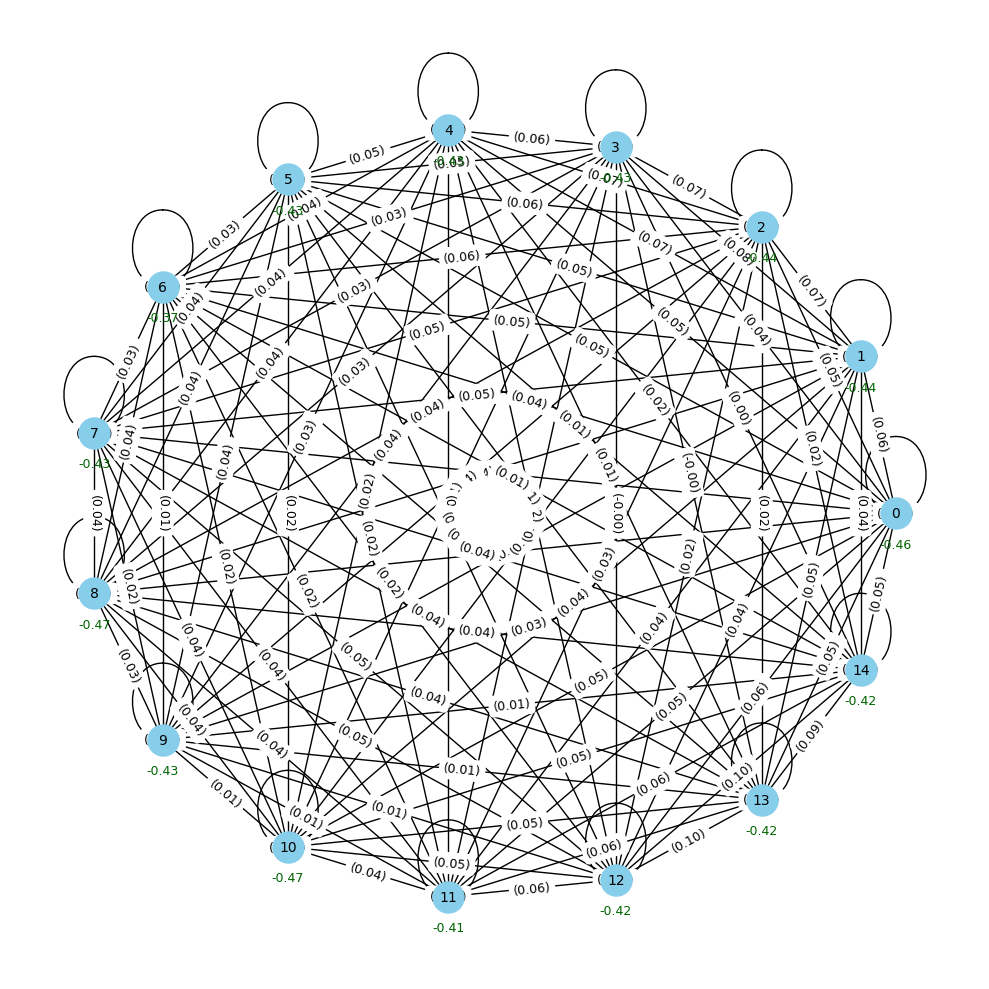

# of nodes: 15, # of edges: 120
Is complete graph?: False


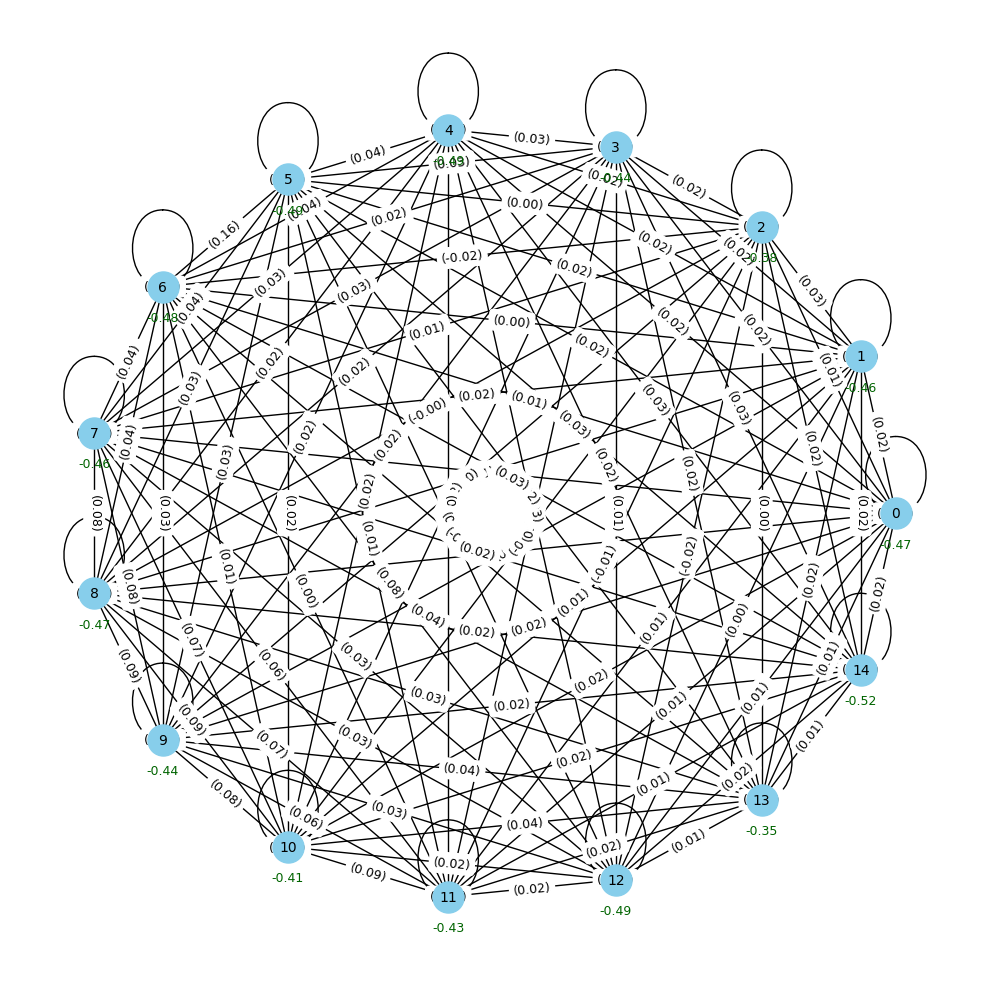

In [16]:
for i in range(2):
    g = graphs_batch[i]
    n_nodes = len(g.nodes)
    n_edges = len(g.edges)
    print(f"# of nodes: {n_nodes}, # of edges: {n_edges}")
    print(f"Is complete graph?: {n_edges == n_nodes * (n_nodes - 1) / 2}")
    draw_networkx_graph(g)

#### Circuits

Draw circuit (output could be pretty large):

In [18]:
# qc = circuits_batch[0]
# qc.h(0)
# qc.measure(0, 0)
# circuit_drawer(qc, output="mpl", style={"backgroundcolor": "#EEEEEE"})

Get the circuit in a layer-wise list format:

In [19]:
# qc = circuits_batch[0]
# dag = circuit_to_dag(qc)

# # Print operations layer by layer
# for i, layer in enumerate(dag.layers()):
#     print(f"Layer {i}:")
#     for op in layer['graph'].op_nodes():
#         # print(f"Params: {op.params}")
#         qubit_labels = [qc.find_bit(q).index for q in op.qargs]
#         clbit_labels = [qc.find_bit(c).index for c in op.cargs]
#         print(f"  {op.name} on qubits {qubit_labels}" + (f", clbits {clbit_labels}" if clbit_labels else ""))

Print circuits with more than $1$ params:

In [20]:
# op_names_exclude = {"barrier", "h", "initialize", "measure"}

# for idx, circuit in enumerate(circuits_batch):
#     for instruction in circuit.data:
#         op_name = instruction.operation.name
#         if op_name in op_names_exclude: # skip unnecessary operations
#             continue
#         params = instruction.operation.params

#         if len(params) > 1:
#             print(f"len(params) > 1 for circuit #{idx:2d}, params: {params}")

Short analysis of the quantum circuit structure:

In [21]:
# op_names_exclude = {"barrier", "h", "initialize", "measure"}

# qubit_labels_str_set = set()
# for circuit in circuits_batch:
#     for idx, instruction in enumerate(circuit.data):
#         op_name = instruction.operation.name
#         if op_name in op_names_exclude: # skip unnecessary operations
#             continue
#         params = instruction.operation.params
#         params_str = "".join(map(lambda x: f"{x:.2f}", params)) # 2-decimal precision
#         qubit_labels = [circuit.qubits.index(qubit) for qubit in instruction.qubits]
#         qubit_labels_str = "(" + ", ".join(map(str, qubit_labels)) + ")"
#         qubit_labels_str_set.add(qubit_labels_str)

# len(qubit_labels_str_set)

In [22]:
# qubit_labels_str_set

### Tokenization

#### Graphs

In [17]:
g = graphs_batch[10]
graph_str = graph_to_str_v1(g)
len(graph_str), graph_str

(1921,
 '<bos> <format_v1> <node_weights_start> -0.46 -0.40 -0.46 -0.33 -0.45 -0.44 -0.36 -0.48 -0.47 -0.41 -0.41 -0.42 -0.48 -0.42 -0.46 <node_weights_end> (0, 1), 0.05, (0, 2), 0.04, (0, 3), 0.04, (0, 4), 0.04, (0, 5), 0.04, (0, 6), 0.04, (0, 7), 0.04, (0, 8), 0.04, (0, 9), 0.04, (0, 10), 0.03, (0, 11), 0.04, (0, 12), 0.03, (0, 13), 0.03, (0, 14), 0.04, (0, 0), 0.05, (1, 2), 0.06, (1, 3), 0.05, (1, 4), 0.05, (1, 5), 0.05, (1, 6), 0.04, (1, 7), 0.05, (1, 8), 0.05, (1, 9), 0.05, (1, 10), 0.04, (1, 11), 0.04, (1, 12), 0.04, (1, 13), 0.04, (1, 14), 0.05, (1, 1), 0.17, (2, 3), 0.05, (2, 4), 0.04, (2, 5), 0.04, (2, 6), 0.05, (2, 7), 0.04, (2, 8), 0.04, (2, 9), 0.03, (2, 10), 0.04, (2, 11), 0.03, (2, 12), 0.03, (2, 13), 0.02, (2, 14), 0.04, (2, 2), 0.17, (3, 4), 0.05, (3, 5), 0.05, (3, 6), 0.03, (3, 7), 0.04, (3, 8), 0.03, (3, 9), 0.03, (3, 10), 0.03, (3, 11), 0.03, (3, 12), 0.03, (3, 13), 0.02, (3, 14), 0.03, (3, 3), 0.42, (4, 5), 0.09, (4, 6), 0.09, (4, 7), 0.09, (4, 8), 0.09, (4, 9), 0.0

In [19]:
graph_tokens = graph_to_tokens_v1(g, version_token="<format_v3_nasdaq>")
len(graph_tokens), graph_tokens[:30]

(260,
 ['<bos>',
  '<format_v3_nasdaq>',
  '<node_weights_start>',
  '-0.46',
  '-0.40',
  '-0.46',
  '-0.33',
  '-0.45',
  '-0.44',
  '-0.36',
  '-0.48',
  '-0.47',
  '-0.41',
  '-0.41',
  '-0.42',
  '-0.48',
  '-0.42',
  '-0.46',
  '<node_weights_end>',
  '(0,1)',
  '0.05',
  '(0,2)',
  '0.04',
  '(0,3)',
  '0.04',
  '(0,4)',
  '0.04',
  '(0,5)',
  '0.04',
  '(0,6)'])

#### Circuits

In [20]:
qc = circuits_batch[0]
op_idx = 199
len(qc), qc.data[op_idx], qc.data[op_idx].params, qc.data[op_idx].qubits, qc.data[op_idx].qubits[0]

(1053,
 CircuitInstruction(operation=Instruction(name='ry', num_qubits=1, num_clbits=0, params=[0.32952901791320444]), qubits=(Qubit(QuantumRegister(15, 'qr154'), 4),), clbits=()),
 [0.32952901791320444],
 (Qubit(QuantumRegister(15, 'qr154'), 4),),
 Qubit(QuantumRegister(15, 'qr154'), 4))

In [21]:
op_names = {qc.data[i].operation.name for i in range(len(qc.data))}
len(op_names), op_names

(6, {'cx', 'ry', 'rz', 'rzz', 'x', 'xx_plus_yy'})

In [22]:
qc = circuits_batch[0]
circuit_str = circuit_to_str_v1(qc)
len(circuit_str), circuit_str[:100], circuit_str[-100:]

(34109,
 '<new_layer_p>, x, [0] <new_layer_p>, x, [1] <new_layer_p>, x, [2] <new_layer_p>, x, [3] <new_layer_p',
 ', 0.770.00 <new_layer_p>, xx_plus_yy, [0, 1], 0.770.00 <new_layer_p>, xx_plus_yy, [14, 0], 0.770.00 ')

In [23]:
circuit_tokens = circuit_to_tokens_v1(qc)
len(circuit_tokens), circuit_tokens[:20], circuit_tokens[-20:]

(4083,
 ['<new_layer_p>',
  'x',
  '[0]',
  '<new_layer_p>',
  'x',
  '[1]',
  '<new_layer_p>',
  'x',
  '[2]',
  '<new_layer_p>',
  'x',
  '[3]',
  '<new_layer_p>',
  'x',
  '[4]',
  '<new_layer_p>',
  'x',
  '[5]',
  '<new_layer_p>',
  'x'],
 ['xx_plus_yy',
  '[4, 5]',
  '0.77',
  '0.00',
  '<new_layer_p>',
  'xx_plus_yy',
  '[2, 3]',
  '0.77',
  '0.00',
  '<new_layer_p>',
  'xx_plus_yy',
  '[0, 1]',
  '0.77',
  '0.00',
  '<new_layer_p>',
  'xx_plus_yy',
  '[14, 0]',
  '0.77',
  '0.00',
  '<end_of_circuit>'])

### Prepare datasets

In [24]:
dataset_dirname = "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/code/nanoGPT/data/graph_qaoa"
dataset_dir = pathlib.Path(dataset_dirname)

In [25]:
len(graphs_batch), len(circuits_batch)

(1460, 1460)

#### Collect all graph-circuit pairs

In [26]:
dataset = []
for idx, (graph, circuit) in enumerate(zip(graphs_batch, circuits_batch)):
    # graph_tokens = graph_to_tokens_v1(graph)                               # use format V1 
    graph_tokens = graph_to_tokens_v1(g, version_token="<format_v3_nasdaq>") # use <format_v3_nasdaq> for Nasdaq data
    circuit_tokens = circuit_to_tokens_v1(circuit)                           # use format V1
    dataset_instance = graph_tokens + circuit_tokens
    dataset.append(dataset_instance)
len(dataset)

1460

#### NOTE! Choose first or second part of the dataset (if chunk is too big)

In [28]:
# # First part of dataset
# half = len(dataset) // 2
# dataset = dataset[:half]
# len(dataset)

In [29]:
# # Second part of dataset
# half = len(dataset) // 2
# dataset = dataset[half:]
# len(dataset)

In [30]:
# # Do it only once for entire dataset

# token_to_id, id_to_token = build_vocab(dataset)

# len(token_to_id), token_to_id

Save vocal, token_to_id, id_to_token info to `meta` file:

In [28]:
# read meta.pkl with format v1 - without node's edges and new tokens for graphs and circuits
meta_filename = "meta.pkl"

# read new meta.pkl with format v2 - with node's edges and new tokens for graphs and circuits
# meta_filename = "meta.pkl"

In [32]:
# # Do it only once for entire dataset
# # Create meta file for all dataset then use it for all data chunks

# # NOTE!
# # Add additional tokens
# max_index = 31  # maximum node/qubit index

# def add_token(token):
#     if token not in token_to_id:
#         idx = len(token_to_id)
#         token_to_id[token] = idx
#         id_to_token[idx] = token

# # Add graph edge tokens like (i,j)
# for i in range(max_index):
#     for j in range(i + 1, max_index):  # i < j avoids duplicates
#         add_token(f"({i},{j})")

# # Add quantum circuit 2-qubit tokens like [i, j]
# for i in range(max_index):
#     for j in range(max_index):
#         add_token(f"[{i}, {j}]")

# # Add single-qubit tokens like [i]
# for i in range(max_index):
#     add_token(f"[{i}]")

# # Add float tokens from -9.99 to 9.99 (inclusive), rounded to 2 decimal digits
# float_range = np.round(np.arange(-9.99, 10.00, 0.01), 2)
# for f in float_range:
#     add_token(f"{f:.2f}")

# meta = {
#     "vocab_size": len(token_to_id),
#     "stoi": token_to_id,
#     "itos": id_to_token,
#     "pad_token_id": 0,
#     "stop_token_id": token_to_id["<end_of_circuit>"]
# }

# with open(dataset_dir / meta_filename, "wb") as fout:
#     pickle.dump(meta, fout)

Read vocal, token_to_id, id_to_token info from `meta` file:

In [30]:
with open(dataset_dir / meta_filename, "rb") as fin:
    meta = pickle.load(fin)
    pad_token_id = meta.get("pad_token_id", 0)
    token_to_id = meta["stoi"]
    id_to_token = meta["itos"]
    vocab_size = meta["vocab_size"]

print(f"found vocab_size = {len(token_to_id)}")

found vocab_size = 37385


Add new tokens to support format v2 or tokens from Nasdaq data (do it only once, then read `meta.pkl` file):

In [37]:
# # NOTE! Do it only once

# def update_meta_pkl(
#     meta_path: pathlib.Path,
#     save_path: pathlib.Path,
#     new_tokens: List[str]
# ) -> None:
#     with open(meta_path, "rb") as fin:
#         meta = pickle.load(fin)
    
#     stoi = meta["stoi"]
#     itos = meta["itos"]
#     next_index = len(itos)

#     added = 0
#     # Add new tokens if they don't exist yet
#     for token in new_tokens:
#         if token not in stoi:
#             stoi[token] = next_index
#             itos[next_index] = token
#             next_index += 1
#             added += 1

#     # Save the updated meta.pkl
#     with open(save_path, "wb") as fout:
#         meta = {
#             "vocab_size": len(stoi),
#             "stoi": stoi,
#             "itos": itos,
#             "pad_token_id": 0,
#             "stop_token_id": token_to_id["<end_of_circuit>"]
#         }
#         pickle.dump(meta, fout)

#     print(f"Added {added} new tokens. Total vocab size: {len(stoi)}")


# # 1. Structural tokens
# # special_tokens = ["(", ")", "<format_v2>", "<node_weights_start>", "<node_weights_end>", "<format_v3_nasdaq>"]

# # 2. Integers from 0 to 100 for node ids and qubit labels
# # int_tokens = [str(i) for i in range(101)]

# # 3. Floats from -9.99 to 9.99 (step = 0.010), rounded to 3 decimal digits
# # float_range = np.round(np.arange(-9.999, 10.000, 0.001), 3)
# # float_tokens = [f"{x:.3f}" for x in float_range] + ["0.000", "0.00", "0.0"]

# # all_new_tokens = special_tokens + int_tokens + float_tokens


# # For Nasdaq only
# special_tokens = ["<format_v3_nasdaq>"]
# min_frequency = 1
# counter = Counter()
# for seq in dataset:
#     counter.update(seq)
# all_tokens_from_dataset = [tok for tok, frequency in counter.items() if frequency >= min_frequency]
# all_tokens_from_dataset = sorted(all_tokens_from_dataset)
# all_new_tokens = special_tokens + all_tokens_from_dataset

# print(len(all_new_tokens), all_new_tokens[:100])
# update_meta_pkl(dataset_dir / "meta.pkl", dataset_dir / "meta_new.pkl", all_new_tokens)

# # The output should looks like this
# # 20109 ['(', ')', '<format_v2>', '<node_weights_start>', '<node_weights_end>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94']
# # Added 20108 new tokens. Total vocab size: 55045

4634 ['<format_v3_nasdaq>', '(0,0)', '(0,1)', '(0,10)', '(0,11)', '(0,12)', '(0,13)', '(0,14)', '(0,2)', '(0,3)', '(0,4)', '(0,5)', '(0,6)', '(0,7)', '(0,8)', '(0,9)', '(1,1)', '(1,10)', '(1,11)', '(1,12)', '(1,13)', '(1,14)', '(1,2)', '(1,3)', '(1,4)', '(1,5)', '(1,6)', '(1,7)', '(1,8)', '(1,9)', '(10,10)', '(10,11)', '(10,12)', '(10,13)', '(10,14)', '(11,11)', '(11,12)', '(11,13)', '(11,14)', '(12,12)', '(12,13)', '(12,14)', '(13,13)', '(13,14)', '(14,14)', '(2,10)', '(2,11)', '(2,12)', '(2,13)', '(2,14)', '(2,2)', '(2,3)', '(2,4)', '(2,5)', '(2,6)', '(2,7)', '(2,8)', '(2,9)', '(3,10)', '(3,11)', '(3,12)', '(3,13)', '(3,14)', '(3,3)', '(3,4)', '(3,5)', '(3,6)', '(3,7)', '(3,8)', '(3,9)', '(4,10)', '(4,11)', '(4,12)', '(4,13)', '(4,14)', '(4,4)', '(4,5)', '(4,6)', '(4,7)', '(4,8)', '(4,9)', '(5,10)', '(5,11)', '(5,12)', '(5,13)', '(5,14)', '(5,5)', '(5,6)', '(5,7)', '(5,8)', '(5,9)', '(6,10)', '(6,11)', '(6,12)', '(6,13)', '(6,14)', '(6,6)', '(6,7)', '(6,8)', '(6,9)']
Added 1393 new t

In [38]:
# # NOTE! Do it once
# # Collect all unique tokens and compare with 'all_new_tokens' from the previous cell

# new_tokens = set()

# # structural tokens
# special_tokens = ["(", ")", "<format_v2>", "<node_weights_start>", "<node_weights_end>"]
# for t in special_tokens:
#     new_tokens.add(t)

# # graphs
# for graph in graphs_batch:
#     for u in graph.nodes:
#         new_tokens.add(f"{graph.nodes[u]['mu']:.3f}")
#         new_tokens.add(f"{u}")
#     for u, v in graph.edges:
#         new_tokens.add(f"{graph.edges[u, v]['weight']:.3f}")

# # circuits
# op_names_exclude = {"barrier", "h", "initialize", "measure"}
# for circuit in circuits_batch:
#     for idx, instruction in enumerate(circuit.data):
#         op_name = instruction.operation.name
#         if op_name in op_names_exclude: # skip unnecessary operations
#             continue

#         params = instruction.operation.params
#         qubit_labels = [circuit.qubits.index(qubit) for qubit in instruction.qubits]

#         for l in qubit_labels:
#             new_tokens.add(f"{l}")
        
#         if params:
#             for i in range(len(params) * 2 - 1):
#                 if i % 2 == 0:
#                     new_tokens.add(f"{params[i % 2]:.2f}")


# print(len(new_tokens), list(new_tokens)[:10], list(new_tokens)[-10:]) # should around 33810

In [39]:
# # all tokens want to add
# all_new_tokens_set = set(all_new_tokens)
# print(len(all_new_tokens_set))

In [40]:
# # all current tokens
# token_to_id_set = set(token_to_id)
# len(token_to_id_set)

In [41]:
# # collected unique tokens - union of want to add tokens and the current tokens
# # the result should be empty
# new_tokens - (token_to_id_set | all_new_tokens_set)

#### Create graph-circuit pairs

Tokenize graph-circuit pairs, sample training pairs fixed context length and padding.

First check the length of tokenized graphs:

In [45]:
from collections import Counter

graph_token_sizes = Counter()
for graph in graphs_batch:
    graph_tokens = graph_to_tokens_v1(graph) # use format V1
    graph_token_sizes[len(graph_tokens)] += 1
graph_token_sizes

Counter({260: 1460})

In [46]:
train_part = 0.9
val_part = 1 - train_part
train_dataset, val_dataset = dataset[:int(len(dataset)*train_part)],\
                             dataset[-int(len(dataset)*val_part)-1:]
len(train_dataset), len(val_dataset)

(1314, 146)

In [48]:
len(train_dataset[0]), train_dataset[0][:50], train_dataset[0][230:280], train_dataset[0][-50:]

(4343,
 ['<bos>',
  '<format_v3_nasdaq>',
  '<node_weights_start>',
  '-0.46',
  '-0.40',
  '-0.46',
  '-0.33',
  '-0.45',
  '-0.44',
  '-0.36',
  '-0.48',
  '-0.47',
  '-0.41',
  '-0.41',
  '-0.42',
  '-0.48',
  '-0.42',
  '-0.46',
  '<node_weights_end>',
  '(0,1)',
  '0.05',
  '(0,2)',
  '0.04',
  '(0,3)',
  '0.04',
  '(0,4)',
  '0.04',
  '(0,5)',
  '0.04',
  '(0,6)',
  '0.04',
  '(0,7)',
  '0.04',
  '(0,8)',
  '0.04',
  '(0,9)',
  '0.04',
  '(0,10)',
  '0.03',
  '(0,11)',
  '0.04',
  '(0,12)',
  '0.03',
  '(0,13)',
  '0.03',
  '(0,14)',
  '0.04',
  '(0,0)',
  '0.05',
  '(1,2)'],
 ['0.07',
  '(10,12)',
  '0.07',
  '(10,13)',
  '0.07',
  '(10,14)',
  '0.05',
  '(10,10)',
  '0.12',
  '(11,12)',
  '0.07',
  '(11,13)',
  '0.07',
  '(11,14)',
  '0.05',
  '(11,11)',
  '0.11',
  '(12,13)',
  '0.06',
  '(12,14)',
  '0.05',
  '(12,12)',
  '0.10',
  '(13,14)',
  '0.05',
  '(13,13)',
  '0.12',
  '(14,14)',
  '0.12',
  '<end_of_graph>',
  '<new_layer_p>',
  'x',
  '[0]',
  '<new_layer_p>',
  'x'

#### Train dataset

Length of tokenized graph is ~212 tokens (for the format v2 ~545 tokens), context size should be larger, e.g. 256, 512, 1024, 2048, etc:

In [49]:
start_t = time.time()
train_pairs = windowed_training_pairs(train_dataset, token_to_id, T=1024, bmin=768, bmax=1024)
end_t = time.time()
print(f"Windowed train pairs were generated. Elapsed time: {end_t - start_t} secs")

start_t = time.time()
save_windowed_training_pairs(train_pairs, dataset_dir / "train")
end_t = time.time()
print(f"Windowed train pairs were saved. Elapsed time: {end_t - start_t} secs")

len(train_pairs), type(train_pairs), len(train_pairs[0][0]), len(train_pairs[0][1])

100%|██████████| 1314/1314 [05:12<00:00,  4.20it/s] 


Windowed train pairs were generated. Elapsed time: 312.70313811302185 secs
Windowed train pairs were saved. Elapsed time: 437.7415580749512 secs


(4530910, list, 1024, 1024)

#### Validation dataset

In [50]:
start_t = time.time()
val_pairs = windowed_training_pairs(val_dataset, token_to_id, T=1024, bmin=768, bmax=1024)
end_t = time.time()
print(f"Windowed validation pairs were generated. Elapsed time: {end_t - start_t} secs")

start_t = time.time()
save_windowed_training_pairs(val_pairs, dataset_dir / "val")
end_t = time.time()
print(f"Windowed validation pairs were saved. Elapsed time: {end_t - start_t} secs")

len(val_pairs), type(val_pairs), len(val_pairs[0][0]), len(val_pairs[0][1])

100%|██████████| 146/146 [00:11<00:00, 13.05it/s]


Windowed validation pairs were generated. Elapsed time: 11.194074153900146 secs
Windowed validation pairs were saved. Elapsed time: 34.59909796714783 secs


(501570, list, 1024, 1024)

#### Check compression ratio

In [44]:
# filename = f"/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/code/nanoGPT/data/graph_qaoa/val_third_batch_batch3_50_pairs.npz"

# data_npz = np.load(filename)
# x = data_npz["x"]
# y = data_npz["y"]

# x.shape, y.shape

In [45]:
# import numpy
# import zipfile

# def is_compressed(npz_file):
#     zip_infos = npz_file.zip.infolist()
#     if len(zip_infos) == 0:
#         raise RuntimeError("Did not find ZipInfos unexpectedly")
#     compress_type = zip_infos[0].compress_type
#     if compress_type == zipfile.ZIP_STORED:
#         return False
#     elif compress_type == zipfile.ZIP_DEFLATED:
#         return True
#     else:
#         raise ValueError("Unexpected compression type")

In [46]:
# filename2 = f"/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/code/nanoGPT/data/graph_qaoa/val_01.npz"
# filename3 = f"/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/code/nanoGPT/data/graph_qaoa/train_third_batch_batch3_200_pairs.npz"

In [47]:
# a = numpy.load(filename)
# b = numpy.load(filename2)
# c = numpy.load(filename3)
# print(is_compressed(a))
# print(is_compressed(b))
# print(is_compressed(c))

In [48]:
# c = numpy.load(filename3)
# x = c["x"]
# y = c["y"]
# print(x.shape, y.shape)
# output_filename = "/Users/andxeg/Projects/Quantum/International_Year_of_Quantum_Global_Industry_Challenge/code/nanoGPT/data/graph_qaoa/train_third_batch_batch3_200_pairs_compressed"
# np.savez_compressed(output_filename, x=x, y=y)

## Free memory

In [49]:
# import gc
# gc.collect()

In [1]:
output_scheme = "<new_layer_p> rz [0] -9.50 <new_layer_p> rz [12] 212.62 <new_layer_p> rz [9] 0.76 <end_of_graph> <new_layer_p> rz [0] -8.49 <new_layer_p> rz [5] -9.20 <new_layer_p> rz [3] 209.18 (5,10) 0.89 <end_of_graph> <new_layer_p> rz [9] -9.50 <new_layer_p> rz [3] -10.61 <new_layer_p> rz [9] -8.64 <new_layer_p> rz [0] -9.16 <new_layer_p> rz [12] -7.35 <new_layer_p> rz [9] 212.17 (10,13) 0.38 (8,10) 0.90 <end_of_graph> <new_layer_p> rz [9] 0.35 (12,14) 0.99 <end_of_graph> <new_layer_p> rz [14] -8.98 <new_layer_p> rzz [5, 13] rzz [0, 1] 0.73 <end_of_graph> <new_layer_p> rzz [3, 10] 0.92 <end_of_graph> <new_layer_p> rzz [8, 12] 0.02 <end_of_graph> <new_layer_p> rzz [4, 11] 0.28 (10,13) 0.87 <end_of_graph> <new_layer_p> rzz [4, 9] 0.01 <end_of_graph> <new_layer_p> rzz [0, 4] 0.89 <end_of_graph> <new_layer_p> rzz [4, 14] -9.65 <new_layer_p> rzz [13, 14] 3.14 (10,14) 0.01 <end_of_graph> <new_layer_p> rzz [8, 10] 0.83 <end_of_graph> <new_layer_p> rzz [6, 8] 3.14 <end_of_graph> <new_layer_p> rzz [9, 10] ryy [3, 6] ryy [13, 14] 0.04 <end_of_graph> <new_layer_p> rzz [3, 5] 0.01 <end_of_graph> <new_layer_p> ryy [5, 11] rzz [1, 8] 3.13 <new_layer_p> ryy [10, 14] 3.14 (9,12) 0.90 (8,9) 0.79 <new_layer_p> rzz [4, 5] 0.01 <end_of_graph> <new_layer_p> rzz [3, 6] 0.92 <new_layer_p> ryy [8, 12] 0.02 <end_of_graph> <new_layer_p> rz [0] -9.29 <new_layer_p> ryy [4, 11] 3.14 (10,14) 0.90 (12,14) 0.58 (10,13) 0.58 (10,14) 0.30 (12,13) 0.46 (10,14) 0.15 (8,10) 0.61 (9,12) 0.38 (12,14) 0.73 <new_layer_p> rxx [8, 13] 3.14 (10,14) 0.08 (12,14) 0.87 <end_of_graph> <new_layer_p> rzz [3, 11] 0.02 <end_of_graph> <new_layer_p> rzz [0, 8] 0.19 (10,13) 0.90 (7,14) 0.41 (1,13) 0.43 (13,14) 0.87 <end_of_graph> <new_layer_p> rzz [0, 6] 0.74 <new_layer_p> rxx [0, 3] 0.92 <new_layer_p> rz [7] -9.14 <new_layer_p> rzz [0, 6] 1.53 <new_layer_p> rxx [2, 12] 3.14 (9,12) 0.25 (6,8) 0.15 (11,14) 0.22 (0,9) 0.27 (10,14) 0.21 (10,14) 0.86 <end_of_graph> <new_layer_p> ryy [11, 14] 0.01 <new_layer_p> rxx [5, 7] 0.01 <new_layer_p> ryy [8, 14] 0.02 <new_layer_p> ryy [0, 6] 1.31 <new_layer_p> ryy [0, 2] 0.02 <new_layer_p> rxx [0, 1] 0.89 <new_layer_p> rxx [3, 5] 0.01 <new_layer_p> rzz [2, 12] 3.14 <new_layer_p> rxx [13, 14] 3.14 (9,12) 0.98 (6,9) 0.31 (11,14) 0.10 (8,9) 0.87 <end_of_graph> <new_layer_p> ryy [11, 14] -0.01 <new_layer_p> ryy [1, 10] 0.01 <new_layer_p> rxx [13, 14] 3.14 <new_layer_p> ryy [5, 7] 0.01 <new_layer_p> rzz [5, 6] 3.14 <new_layer_p> rxx [6, 11] 3.14 (9,12) 0.62 (11,14) 0.10 (8,9) 0.71 (10,14) 0.90 (12,14) 0.15 (10,11) 0.95 <end_of_graph> <new_layer_p> rzz [4, 11] 0.02 <new_layer_p> ryy [2, 5] rxx [1, 3] 0.02 <new_layer_p> rxx [3, 4] 3.14 <new_layer_p> ryy [6, 13] 3.14 <new_layer_p> rxx [13, 14] 3.14 <new_layer_p> ryy [8, 11] 0.02 <new_layer_p> rzz [6, 14] 3.14 <new_layer_p> rxx [3, 10] 0.01 <new_layer_p> ryy [0, 3] 1.52 <new_layer_p> ryy [2, 3] 3.13 <new_layer_p> rxx [7, 9] 0.92 <new_layer_p> ryy [4, 13] 0.02 <new_layer_p> rxx [0, 7] 3.14 <new_layer_p> rxx [6, 10] 0.01 <new_layer_p> ryy [9, 14] 0.02 <new_layer_p> ryy [1, 2] 0.02 <new_layer_p> rxx [9, 10] 0.02 <new_layer_p> ryy [0, 7] 3.14 <new_layer_p> ryy [3, 10] 0.02 <new_layer_p> ryy [12, 14] 3.14 <new_layer_p> rxx [4, 11] 3.14 <new_layer_p> ryy [4, 11] 3.14 <new_layer_p> ryy [0, 3] 3.14 <new_layer_p> ryy [4, 12] 0.89 <new_layer_p> ryy [0, 1] 3.14 <new_layer_p> ryy [13, 14] 0.02 <new_layer_p> ryy [2, 12] 3.14 <new_layer_p> ryy [2, 10] 3.14 <new_layer_p> ryy [1, 9] 0.01 <new_layer_p> rxx [3, 10] 3.14 <new_layer_p> rzz [4, 7] 0.02 <new_layer_p> ryy [0, 8] 3.14 <new_layer_p> rxx [3, 6] ryy [4, 10] 0.02 <new_layer_p> ryy [0, 5] 3.14 <new_layer_p> rzz [0, 4] 3.14 <new_layer_p> ryy [4, 14] 0.02 <new_layer_p> rxx [5, 13] 3.14 <new_layer_p> rxx [0, 1] 0.02 <new_layer_p> rxx [7, 14] 0.02 <new_layer_p> rxx [1, 13] 0.02 <new_layer_p> ryy [5, 10] 3.14 <new_layer_p> ryy [1, 10] 0.02 <new_layer_p> rxx [3, 5] 0.01 <new_layer_p> rxx [4, 6] -0.01 <new_layer_p> rxx [0, 2] 3.14 <new_layer_p> rxx [12, 14] 3.14 <new_layer_p> ryy [3, 10] 3.14 <new_layer_p> ryy [1, 13] 0.01 <new_layer_p> rxx [10, 13] 3.14 <new_layer_p> rzz [3, 11] 3.14 <new_layer_p> rxx [5, 14] 0.02 <new_layer_p> ryy [7, 8] 3.14 <new_layer_p> ryy [2, 12] 3.14 <new_layer_p> rxx [5, 12] 3.14 <new_layer_p> ryy [10, 12] 0.02 <new_layer_p> ryy [11, 12] 0.02 <new_layer_p> rxx [3, 6] 0.02 <new_layer_p> rxx [1, 6] 0.00 <new_layer_p> rxx [1, 9] 0.02 <new_layer_p> ryy [6, 11] 3.14 <new_layer_p> rxx [4, 11] 0.01 <new_layer_p> ryy [4, 10] 0.02 <new_layer_p> rxx [9, 14] 0.02 <new_layer_p> ryy [11, 14] 0.01 <new_layer_p> rxx [3, 5] 3.14 <new_layer_p> ryy [5, 8] 0.01 <new_layer_p> rxx [3, 4] 3.14 <new_layer_p> rxx [3, 11] 0.02 <new_layer_p> ryy [8, 13] 3.14 <new_layer_p> ryy [2, 14] 3.14 <new_layer_p> ryy [6, 7] 3.14 <new_layer_p> ryy [2, 9] 0.01 <new_layer_p> rxx [1, 6] 3.14 <new_layer_p> ryy [4, 12] 1.27 <new_layer_p> rxx [8, 12] 3.14 <new_layer_p> ryy [9, 10] 3.14 <new_layer_p> ryy [3, 5] 0.02 <new_layer_p> rzz [6, 11] 0.02 <new_layer_p> rxx [0, 2] 0.02 <new_layer_p> ryy [8, 12] 0.01 <new_layer_p> ryy [2, 5] 3.14 <new_layer_p> rxx [5, 12] 3.14 <new_layer_p> rxx [3, 5] 0.01 <new_layer_p> rxx [11, 13] 0.02 <new_layer_p> ryy [1, 8] 3.14 <new_layer_p> ryy [5, 7] 3.14 <new_layer_p> ryy [10, 11] 3.14 <new_layer_p> ryy [4, 8] 0.02 <new_layer_p> ryy [1, 14] 0.02 <new_layer_p> rxx [1, 10] 0.01 <new_layer_p> rxx [13, 14] 3.14 <new_layer_p> rxx [4, 9] 3.14 <new_layer_p> ryy [2, 10] 3.14 <new_layer_p> ryy [8, 11] 3.14 <new_layer_p> ryy [7, 14] 3.14 <new_layer_p> rxx [4, 7] 0.01 <new_layer_p> ryy [5, 9] 0.02 <new_layer_p> ryy [1, 7] 3.14 <new_layer_p> rxx [1, 6] 3.14 <new_layer_p> rxx [0, 7] 0.01 <new_layer_p> ryy [3, 11] -0.01 <new_layer_p> rxx [7, 13] 3.14 <new_layer_p> rxx [6, 10] 0.01 <new_layer_p> rxx [0, 5] 3.14 <new_layer_p> ryy [2, 10] 0.02 <new_layer_p> ryy [4, 9] 3.14 <new_layer_p> ryy [3, 6] 3.14 <new_layer_p> ryy [5, 7] 3.14 <new_layer_p> rxx [3, 11] 3.13 <new_layer_p> rxx [3, 7] 3.15 <new_layer_p> rxx [11, 12] 3.14 <new_layer_p> ryy [7, 11] 3.14 <new_layer_p> rxx [4, 13] 3.14 <new_layer_p> ryy [4, 8] 0.02 <new_layer_p> rxx [8, 13] 0.02 <new_layer_p> rxx [10, 12] 1.16 <new_layer_p> rxx [6, 9] 3.14 <new_layer_p> rxx [4, 6] 0.02 <new_layer_p> ryy [1, 3] 3.14 <new_layer_p> ryy [1, 13] 0.01 <new_layer_p> ryy [0, 2] 3.14 <new_layer_p> ryy [3, 14] 3.14 <new_layer_p> ryy [3, 7] 0.02 <new_layer_p> ryy [2, 12] 0.01 <new_layer_p> rxx [0, 4] 3.13 <new_layer_p> ryy [6, 12] 0.01 <new_layer_p> ryy [11, 12] 3.14 <new_layer_p> ryy [0, 10] 3.14 <new_layer_p> ryy [3, 11] 0.02 <new_layer_p> rxx [1, 7] 3.14 <new_layer_p> ryy [12, 13] 0.01 <new_layer_p> ryy [2, 8] 3.14 <new_layer_p> ryy [12, 13] 3.14 <new_layer_p> rxx [6, 11] 3.14 <new_layer_p> rxx [2, 3] 0.02 <new_layer_p> rxx [4, 12] 3.14 <new_layer_p> ryy [5, 13] 0.02 <new_layer_p> ryy [2, 6] 3.14 <new_layer_p> ryy [1, 10] 3.15 <new_layer_p> ryy [4, 13] 0.01 <new_layer_p> rxx [1, 10] 0.02 <new_layer_p> ryy [5, 12] 3.14 <new_layer_p> ryy [8, 9] 3.14 <new_layer_p> rxx [3, 10] 3.13 <new_layer_p> ryy [5, 14] 3.14 <new_layer_p> ryy [0, 9] 3.14 <new_layer_p> ryy [1, 13] 0.02 <new_layer_p> rxx [1, 4] 3.14 <new_layer_p> ryy [1, 12] 0.02 <new_layer_p> ryy [2, 11] 3.14 <new_layer_p> ryy [5, 6] 3.14 <new_layer_p> rxx [9, 14] 3.13 <new_layer_p> ryy [5, 13] 0.02 <new_layer_p> ryy [3, 14] 0.02 <new_layer_p> ryy [5, 13] 3.14 <new_layer_p> ryy [2, 4] 3.14 <new_layer_p> ryy [1, 6] 3.14 <new_layer_p> ryy [0, 3] 3.14 <new_layer_p> ryy [0, 8] 3.14 <new_layer_p> ryy [6, 11] 0.01 <new_layer_p> rxx [11, 12] 0.02 <new_layer_p> ryy [2, 6] 0.01 <new_layer_p> ryy [0, 12] 3.14 <new_layer_p> ryy [8, 10] 0.02 <new_layer_p> ryy [4, 6] 3.14 <new_layer_p> ryy [2, 10] 3.14 <new_layer_p> ryy [12, 14] 0.02 <new_layer_p> rxx [1, 10] 0.01 <new_layer_p> ryy [5, 6] 0.02 <new_layer_p> ryy [1, 6] 0.01 <new_layer_p> ryy [1, 13] -0.01 <new_layer_p> rxx [2, 13] 3.14 <new_layer_p> rxx [4, 10] 0.02 <new_layer_p> ryy [8, 11] 0.01 <new_layer_p> ryy [1, 6] 0.02 <new_layer_p> rxx [3, 6] 0.01 <new_layer_p> rxx [2, 13] 0.01 <new_layer_p> rxx [7, 10] 3.14 <new_layer_p> ryy [4, 7] 0.01 <new_layer_p> ryy [1, 2] 0.02 <new_layer_p> rxx [8, 12] 3.14 <new_layer_p> ryy [0, 4] 0.01 <new_layer_p> ryy [13, 14] 0.01 <new_layer_p> ryy [3, 13] 3.14 <new_layer_p> ryy [3, 5] 0.02 <new_layer_p> ryy [0, 14] 0.01 <new_layer_p> ryy [3, 8] 0.02 <new_layer_p> ryy [7, 14] 0.02 <new_layer_p> ryy [2, 6] 0.01 <new_layer_p> ryy [4, 13] 0.02 <new_layer_p> rxx [10, 14] -0.01 <new_layer_p> ryy [0, 2] 3.14 <new_layer_p> ryy [8, 10] 0.01 <new_layer_p> rxx [7, 14] 3.14 <new_layer_p> rxx [9, 12] 3.14 <new_layer_p> rxx [3, 6] 3.14 <new_layer_p> ryy [8, 13] 3.14 <new_layer_p> rxx [8, 10] 3.14 <new_layer_p> rxx [1, 11] 3.14 <new_layer_p> ryy [2, 5] 3.14 <new_layer_p> ryy [1, 9] 0.02 <new_layer_p> rxx [13, 14] 3.14 <new_layer_p> ryy [2, 3] 3.14 <new_layer_p> rxx [1, 10] 0.02 <new_layer_p> ryy [4, 6] 3.14 <new_layer_p> ryy [0, 11] 0.01 <new_layer_p> ryy [4, 11] 0.02 <new_layer_p> ryy [0, 13] 3.14 <new_layer_p> ryy [7, 13] 3.14 <new_layer_p> ryy [5, 6] 3.13 <new_layer_p> rxx [5, 13] 0.02 <new_layer_p> ryy [0, 6] 0.01 <new_layer_p> rxx [3, 14] 3.14 <new_layer_p> rxx [0, 6] 0.02 <new_layer_p> ryy [1, 14] -0.02 <new_layer_p> ryy [4, 11] 0.02 <new_layer_p> ryy [4, 14] 3.14 <new_layer_p> rxx [4, 8] 3.14 <new_layer_p> rxx [0, 4] 0.02 <new_layer_p> ryy [4, 11] 3.14 <new_layer_p> ryy [10, 13] 3.14 <new_layer_p> rxx [3, 6] 0.01 <new_layer_p> ryy [1, 13] 3.14 <new_layer_p> ryy [6, 8] 0.02 <new_layer_p> rxx [1, 6] 3.13 <new_layer_p> rxx [2, 6] 3.14 <new_layer_p> ryy [1, 5] 3.14 <new_layer_p> rxx [6, 8] 0.02 <new_layer_p> rxx [12, 14] 3.13 <new_layer_p> rxx [2, 8] 3.14 <new_layer_p> ryy [0, 10] 0.02 <new_layer_p> ryy [9, 11] 0.02 <new_layer_p> ryy [4, 8] 3.14 <new_layer_p> ryy [3, 8] 3.14 <new_layer_p> rxx [1, 13] 3.14 <new_layer_p> ryy [7, 9] 0.01 <new_layer_p> ryy [8, 10] 3.14 <new_layer_p> ryy [6, 11] 3.14 <new_layer_p> ryy [7, 12] 3.14 <new_layer_p> ryy [3, 8] 0.00 <new_layer_p> rxx [0, 5] 3.14 <new_layer_p> rxx [3, 6] 3.14 <new_layer_p> rxx [0, 13] 0.02 <new_layer_p> ryy [6, 11] 3.14 <new_layer_p> ryy [6, 10] 0.02 <new_layer_p> rxx [8, 12] 0.02 <new_layer_p> rxx [5, 13] 3.14 <new_layer_p> rxx [11, 14] 3.14 <new_layer_p> rxx [10, 14] 3.14 <new_layer_p> ryy [6, 8] 3.14 <new_layer_p> ryy [13, 14] 3.14 <new_layer_p> ryy [7, 13] 0.02 <new_layer_p> ryy [0, 9] 0.02 <new_layer_p> rxx [2, 14] 3.14 <new_layer_p> ryy [7, 12] 3.13 <new_layer_p> ryy [9, 11] 3.14 <new_layer_p> rxx [1, 7] 0.02 <new_layer_p> ryy [1, 5] 3.14 <new_layer_p> ryy [2, 6] 3.14 <new_layer_p> ryy [6, 8] 3.14 <new_layer_p> rxx [3, 4] 3.15 <new_layer_p> ryy [11, 12] 0.02 <new_layer_p> ryy [3, 14] 3.14 <new_layer_p> ryy [5, 6] 0.02 <new_layer_p> ryy [12, 14] 3.14 <new_layer_p> ryy [2, 7] 3.14 <new_layer_p> rxx [0, 5] 3.14 <new_layer_p> ryy [3, 9] 0.02 <new_layer_p> ryy [1, 8] 0.02 <new_layer_p> rxx [4, 5] 3.14 <new_layer_p> rxx [3, 8] 0.02 <new_layer_p> ryy [6, 10] 0.02 <new_layer_p> rxx [2, 13] 3.14 <new_layer_p> ryy [3, 12] 3.14 <new_layer_p> ryy [1, 12] 3.14 <new_layer_p> ryy [2, 7] 3.14 <new_layer_p> rxx [0, 4] 3.14 <new_layer_p> rxx [7, 14] 3.14 <new_layer_p> ryy [2, 8] 3.14 <new_layer_p> ryy [7, 14] 3.14 <new_layer_p> ryy [7, 12] 0.01 <new_layer_p> ryy [9, 11] 0.01 <new_layer_p> ryy [10, 14] 3.14 <new_layer_p> rxx [11, 12] 0.02 <new_layer_p> rxx [8, 10] 3.14 <new_layer_p> ryy [0, 6] 3.14 <new_layer_p> rxx [5, 10] 3.14 <new_layer_p> ryy [12, 14] 3.14 <new_layer_p> ryy [3, 10] 3.14 <new_layer_p> ryy [9, 13] 0.02 <new_layer_p> ryy [6, 8] 3.14 <new_layer_p> ryy [6, 8] 3.14 <new_layer_p> rxx [9, 10] 3.14 <new_layer_p> ryy [6, 9] 3.12 <new_layer_p> rxx [1, 10] 3.14 <new_layer_p> ryy [0, 14] 0.01 <new_layer_p> ryy [10, 14] 3.14 <new_layer_p> ryy [9, 10] 3.14 <new_layer_p> rxx [3, 6] 0.01 <new_layer_p> ryy [6, 12] 3.14 <new_layer_p> rxx [4, 5] 3.13 <new_layer_p> rxx [10, 11] 0.02 <new_layer_p> ryy [1, 5] 3.14 <new_layer_p> ryy [7, 11] 0.02 <new_layer_p> ryy [9, 10] 3.14 <new_layer_p> ryy [5, 13] 0.01 <new_layer_p> ryy [1, 5] 3.14 <new_layer_p> rxx [4, 14] 0.02 <new_layer_p> ryy [10, 14] 3.14 <new_layer_p> ryy [4, 5] 3.14 <new_layer_p> ryy [12, 14] 3.14 <new_layer_p> ryy [0, 4] 0.02 <new_layer_p> ryy [7, 13] 0.01 <new_layer_p> rxx [0, 13] 3.14 <new_layer_p> ryy [5, 6] 0.02 <new_layer_p> ryy [3, 10] 0.02 <new_layer_p> ryy [2, 10] 3.14 <new_layer_p> ryy [0, 4] 0.02 <new_layer_p> ryy [5, 7] 3.14 <new_layer_p> rxx [8, 11] 3.14 <new_layer_p> ryy [0, 7] 3.14 <new_layer_p> ryy [9, 10] 0.02 <new_layer_p> ryy [12, 13] 3.14 <new_layer_p> ryy [6, 8] 3.14 <new_layer_p> ryy [7, 14] 0.02 <new_layer_p> ryy [6, 9] 0.02 <new_layer_p> ryy [1, 8] 0.01 <new_layer_p> ryy [6, 13] 3.14 <new_layer_p> rxx [1, 4] 3.13 <new_layer_p> rxx [9, 14] 0.02 <new_layer_p> rxx [3, 14] 3.13 <new_layer_p> ryy [8, 11] 3.13 <new_layer_p> ryy [2, 7] 3.14 <new_layer_p> ryy [0, 10] 3.14 <new_layer_p> ryy [2, 14] 3.14 <new_layer_p> ryy [6, 13] 3.13 <new_layer_p> ryy [6, 8] 3.14 <new_layer_p> ryy [7, 13] 3.14 <new_layer_p> ryy [6, 7] 3.14 <new_layer_p> ryy [6, 13] 3.13 <new_layer_p> rxx [1, 6] 0.02 <new_layer_p> ryy [2, 10] 3.14 <new_layer_p> rxx [1, 10] 3.14 <new_layer_p> rxx [1, 3] 3.14 <new_layer_p> rxx [2, 5] 3.14 <new_layer_p> ryy [2, 6] 0.02 <new_layer_p> ryy [12, 13] 0.02 <new_layer_p> ryy [1, 3] 3.14 <new_layer_p> ryy [3, 14] 3.14 <new_layer_p> ryy [0, 1] 3.14 <new_layer_p> rxx [6, 10] 0.02 <new_layer_p> ryy [6, 11] 0.01 <new_layer_p> ryy [1, 11] 3.14 <new_layer_p> rxx [4, 8] 0.02 <new_layer_p> ryy [7, 14] 3.14 <new_layer_p> ryy [10, 11] 0.02 <new_layer_p> rxx [4, 12] 0.02 <new_layer_p> rxx [3, 9] 3.11 <new_layer_p> rxx [3, 6] 3.14 <new_layer_p> ryy [0, 4] 0.02 <new_layer_p> ryy [11, 13] 3.14 <new_layer_p> ryy [1, 6] 3.14 <new_layer_p> ryy [0, 8] 3.14 <new_layer_p> ryy [3, 6] 3.14 <new_layer_p> rxx [9, 14] 3.14 <new_layer_p> ryy [7, 9] 3.14 <new_layer_p> rxx [8, 12] 3.14 <new_layer_p> ryy [2, 7] 3.14 <new_layer_p> ryy [7, 14] 0.02 <new_layer_p> rxx [0, 3] 0.01 <new_layer_p> ryy [5, 6] 3.14 <new_layer_p> rxx [4, 14] 3.14 <new_layer_p> ryy [7, 13] 3.14 <new_layer_p> ryy [3, 14] 3.14 <new_layer_p> rxx [4, 14] 3.14 <new_layer_p> ryy [0, 4] 0.02 <new_layer_p> ryy [4, 12] 0.01 <new_layer_p> rxx [3, 10] 3.14 <new_layer_p> ryy [9, 10] 3.14 <new_layer_p> ryy [6, 14] 3.14 <new_layer_p> rxx [5, 11] 3.14 <new_layer_p> ryy [3, 6] 3.14 <new_layer_p> rxx [1, 11] 0.02 <new_layer_p> ryy [6, 7] 3.14 <new_layer_p> ryy [13, 14] 3.14 <new_layer_p> rxx [5, 7] 3.14 <new_layer_p> rxx [12, 13] 3.14 <new_layer_p> rxx [4, 11] 0.02 <new_layer_p> rxx [2, 10] 0.02 <new_layer_p> ryy [1, 10] 0.01 <new_layer_p> ryy [1, 5] 3.13 <new_layer_p> ryy [8, 10] 0.02 <new_layer_p> ryy [7, 10] 0.01 <new_layer_p> ryy [3, 6] 0.02 <new_layer_p> rxx [10, 11] 0.02 <new_layer_p> ryy [12, 13] 3.14 <new_layer_p> ryy [3, 8] 3.14 <new_layer_p> ryy [3, 6] 0.02 <new_layer_p> ryy [0, 1] 0.02 <new_layer_p> ryy [2, 14] 3.14 <new_layer_p> ryy [2, 6] 0.02 <new_layer_p> ryy [1, 9] 0.02 <new_layer_p> rxx [3, 11] 3.14 <new_layer_p> ryy [4, 11] 0.01 <new_layer_p> ryy [2, 5] 0.01 <new_layer_p> ryy [9, 13] 3.14 <new_layer_p> ryy [1, 6] 3.14 <new_layer_p> ryy [8, 14] 3.14 <new_layer_p> ryy [0, 1] 3.14 <new_layer_p> ryy [0, 6] 3.14 <new_layer_p> rxx [6, 13] 0.02 <new_layer_p> ryy [5, 6] 3.14 <new_layer_p> ryy [0, 6] 0.02 <new_layer_p> rxx [2, 14] -0.02 <new_layer_p> ryy [3, 10] 3.14 <new_layer_p> rxx [1, 6] 0.02 <new_layer_p> rzz [11, 14] 3.14 <new_layer_p> ryy [10, 13] 0.01 <new_layer_p> ryy [8, 10] 3.14 <new_layer_p> ryy [5, 8] 3.14 <new_layer_p> ryy [4, 5] 3.14 <new_layer_p> ryy [11, 12] 0.02 <new_layer_p> rxx [1, 9] 3.14 <new_layer_p> rxx [8, 14] 0.02 <new_layer_p> rzz [1, 5] 3.14 <new_layer_p> ryy [6, 11] 0.02 <new_layer_p> rxx [1, 2] 0.01 <new_layer_p> rxx [5, 8] 3.14 <new_layer_p> rxx [4, 6] 3.14 <new_layer_p> rxx [0, 6] 0.01 <new_layer_p> rxx [4, 10] 0.01 <new_layer_p> ryy [4, 11] 3.14 <new_layer_p> ryy [0, 10] 0.02 <new_layer_p> ryy [7, 13] 0.02 <new_layer_p> ryy [6, 8] 3.14 <new_layer_p> rxx [1, 6] 3.14 <new_layer_p> rxx [2, 8] 3.14 <new_layer_p> ryy [4, 9] 3.14 <new_layer_p> ryy [6, 8] 0.02 <new_layer_p> ryy [1, 12] 3.14 <new_layer_p> ryy [7, 14] 3.14 <new_layer_p> rxx [2, 10] 3.14 <new_layer_p> rxx [4, 14] 3.14 <new_layer_p> ryy [1, 10] 3.14 <new_layer_p> rxx [6, 11] 0.02 <new_layer_p> ryy [12, 14] 3.14 <new_layer_p> rxx [2, 9] 3.14 <new_layer_p> ryy [6, 14] 3.14 <new_layer_p> ryy [4, 14] 3.14 <new_layer_p> rxx [4, 5] 0.02 <new_layer_p> rxx [6, 8] 3.14 <new_layer_p> ryy [4, 6] 3.14 <new_layer_p> ryy [6, 10] 3.12 <new_layer_p> ryy [8, 10] 3.13 <new_layer_p> rxx [0, 4] 3.14 <new_layer_p> ryy [4, 13] 3.11 <new_layer_p> ryy [9, 10] 0.02 <new_layer_p> ryy [6, 7] 3.14 <new_layer_p> rxx [2, 10] 3.14 <new_layer_p> rxx [2, 8] 3.14 <new_layer_p> ryy [9, 10] 3.14 <new_layer_p> ryy [1, 6] 3.14 <new_layer_p> rxx [0, 13] 3.14 <new_layer_p> ryy [10, 14] 3.14 <new_layer_p> ryy [0, 12] 0.02 <new_layer_p> rxx [3, 14] 3.14 <new_layer_p> rxx [1, 4] 0.02 <new_layer_p> ryy [2, 4] 3.14 <new_layer_p> rxx [1, 12] 0.02 <new_layer_p> ryy [8, 9] 3.14 <new_layer_p> ryy [0, 8] 3.14 <new_layer_p> rxx [1, 13] 3.14 <new_layer_p> ryy [1, 5] 3.14 <new_layer_p> ryy [8, 10] 0.01 <new_layer_p> rxx [7, 9] 3.14 <new_layer_p> ryy [3, 5] 0.02 <new_layer_p> rxx [6, 11] 0.02 <new_layer_p> ryy [6, 7] 0.02 <new_layer_p> ryy [0, 2] 0.01 <new_layer_p> ryy [0, 7] 3.14 <new_layer_p> ryy [2, 3] 0.02 <new_layer_p> rxx [10, 12] 0.02 <new_layer_p> rxx [12, 13] 3.14 <new_layer_p> rxx [0, 3] 3.14 <new_layer_p> ryy [8, 9] 3.14 <new_layer_p> ryy [7, 11] 3.14 <new_layer_p> ryy [1, 10] 0.02 <new_layer_p> rxx [5, 14] 3.14 <new_layer_p> ryy [0, 6] -0.02 <new_layer_p> ryy [0, 4] 3.14 <new_layer_p> ryy [2, 11] 3.14 <new_layer_p> rxx [7, 10] 3.14 <new_layer_p> ryy [4, 8] 0.02 <new_layer_p> ryy [4, 12] 0.02 <new_layer_p> rxx [6, 7] 3.14 <new_layer_p> ryy [1, 10] 0.02 <new_layer_p> ryy [5, 6] 3.14 <new_layer_p> ryy [0, 6] 0.02 <new_layer_p> ryy [7, 12] 3.14 <new_layer_p> rxx [1, 10] 0.01 <new_layer_p> rxx [4, 5] 0.02 <new_layer_p> ryy [0, 13] 0.01 <new_layer_p> rxx [0, 14] 3.11 <new_layer_p> rxx [4, 6] 0.02 <new_layer_p> ryy [10, 14] 3.14 <new_layer_p> rxx [6, 7] 3.14 <new_layer_p> rxx [11, 13] 0.01 <new_layer_p> rxx [5, 7] 0.01 <new_layer_p> ryy [3, 14] 0.01 <new_layer_p> ryy [5, 6] 0.02 <new_layer_p> rxx [11, 14] 3.14 <new_layer_p> ryy [1, 10] 3.14 <new_layer_p> ryy [4, 5] 0.01 <new_layer_p> ryy [1, 11] 3.14 <new_layer_p> ryy [5, 14] 0.02 <new_layer_p> rxx [0, 12] 3.13 <new_layer_p> ryy [6, 9] 3.14 <new_layer_p> rxx [1, 4] 3.14 <new_layer_p> ryy [5, 14] 3.14 <new_layer_p> ryy [4, 12] 0.01 <new_layer_p> ryy [8, 12] 3.14 <new_layer_p> rxx [0, 10] 0.02 <new_layer_p> rxx [7, 14] 3.11 <new_layer_p> rxx [1, 10] 3.13 <new_layer_p> ryy [1, 8] 0.02 <new_layer_p> rxx [8, 12] 3.14 <new_layer_p> ryy [8, 10] 0.02 <new_layer_p> rxx [1, 5] 3.14 <new_layer_p> rxx [1, 3] 0.01 <new_layer_p> ryy [2, 7] 3.14 <new_layer_p> ryy [1, 6] -0.02 <new_layer_p> ryy [0, 10] 3.14 <new_layer_p> rxx [4, 11] 3.14 <new_layer_p> ryy [7, 12] 0.01 <new_layer_p> ryy [4, 8] 0.00 <new_layer_p> ryy [8, 11] 3.14 <new_layer_p> ryy [1, 8] 0.02 <new_layer_p> ryy [11, 12] 0.02 <new_layer_p> ryy [0, 3] 0.01 <new_layer_p> ryy [4, 6] 0.02 <new_layer_p> ryy [4, 11] 3.14 <new_layer_p> rxx [1, 7] 3.14 <new_layer_p> rxx [11, 14] 0.02 <new_layer_p> ryy [2, 12] 3.14 <new_layer_p> ryy [11, 13] 3.14 <new_layer_p> ryy [13, 14] 3.14 <new_layer_p> rxx [11, 13] 3.14 <new_layer_p> ryy [7, 14] 3.14 <new_layer_p> ryy [2, 14] 3.14 <new_layer_p> ryy [2, 7] 3.14 <new_layer_p> ryy [1, 8] 3.14 <new_layer_p> ryy [0, 9] 3.14 <new_layer_p> rxx [3, 14] 0.01 <new_layer_p> ryy [4, 5] 3.14 <new_layer_p> ryy [3, 10] 0.01 <new_layer_p> ryy [4, 9] 0.02 <new_layer_p> ryy [0, 6] 3.13 <new_layer_p> rxx [0, 4] 3.14 <new_layer_p> ryy [1, 13] 3.14 <new_layer_p> ryy [4, 6] 3.14 <new_layer_p> rxx [5, 10] 0.02 <new_layer_p> ryy [7, 9] 0.02 <new_layer_p> ryy [10, 14] 3.14 <new_layer_p> rxx [6, 8] 3.14 <new_layer_p> ryy [0, 2] 0.02 <new_layer_p> ryy [0, 7] 0.02 <new_layer_p> ryy [3, 10] 3.14 <new_layer_p> ryy [0, 1] 3.14 <new_layer_p> rxx [5, 11] 3.14 <new_layer_p> rxx [4, 14] 0.02 <new_layer_p> ryy [1, 8] 3.14 <new_layer_p> rxx [7, 12] 3.14 <new_layer_p> rxx [2, 8] 0.02 <new_layer_p> ryy [0, 10] 0.01 <new_layer_p> rxx [4, 14] 0.00 <new_layer_p> ryy [0, 1] 3.14 <new_layer_p> ryy [4, 9] 3.14 <new_layer_p> ryy [1, 11] 3.14 <new_layer_p> ryy [11, 13] 3.14 <new_layer_p> ryy [6, 8] 3.14 <new_layer_p> rxx [0, 13] 3.14 <new_layer_p> ryy [7, 12] 3.14 <new_layer_p> rxx [4, 9] 0.02 <new_layer_p> rxx [2, 10] 3.14 <new_layer_p> ryy [12, 13] 0.02 <new_layer_p> rxx [2, 8] 0.01 <new_layer_p> ryy [7, 9] 3.14 <new_layer_p> rxx [10, 12] 3.14 <new_layer_p> rxx [0, 6] 0.02 <new_layer_p> ryy [1, 10] 0.02 <new_layer_p> ryy [3, 5] 3.14 <new_layer_p> ryy [3, 6] 3.14 <new_layer_p> rxx [2, 4] 3.14 <new_layer_p> ryy [0, 6] 3.14 <new_layer_p> rxx [5, 11] 3.14 <new_layer_p> ryy [5, 10] 3.14 <new_layer_p> rxx [9, 14] 3.14 <new_layer_p> ryy [0, 1] 3.14 <new_layer_p> ryy [13, 14] 0.01 <new_layer_p> ryy [2, 7] 3.14 <new_layer_p> ryy [9, 11] 0.02 <new_layer_p> ryy [6, 13] 0.02 <new_layer_p> ryy [0, 11] 0.01 <new_layer_p> rxx [2, 8] 3.14 <new_layer_p> ryy [4, 13] 3.14 <new_layer_p> rxx [7, 10] 3.14 <new_layer_p> rxx [7, 11] 0.02 <new_layer_p> ryy [0, 8] 3.14 <new_layer_p> ryy [4, 6] 3.14 <new_layer_p> rxx [4, 8] 0.02 <new_layer_p> ryy [0, 14] 3.14 <new_layer_p> ryy [1, 9] 3.14 <new_layer_p> rxx [1, 11] 0.02 <new_layer_p> ryy [3, 6] 0.02 <new_layer_p> ryy [10, 12] 0.02 <new_layer_p> rxx [9, 10] 0.02 <new_layer_p> ryy [7, 11] 0.02 <new_layer_p> rxx [2, 5] 3.14 <new_layer_p> rxx [0, 5] 3.13 <new_layer_p> ryy [2, 7] 0.01 <new_layer_p> rxx [0, 3] 0.02 <new_layer_p> ryy [8, 13] 0.01 <new_layer_p> ryy [0, 11] 3.14 <new_layer_p> rxx [6, 10] 3.14 <new_layer_p> ryy [6, 8] 3.14 <new_layer_p> rxx [6, 9] 0.02 <new_layer_p> ryy [0, 9] 0.02 <new_layer_p> ryy [6, 10] 0.02 <new_layer_p> ryy [8, 12] 3.14 <new_layer_p> ryy [2, 3] 0.02 <new_layer_p> rxx [4, 5] 0.02 <new_layer_p> ryy [8, 10] 0.02 <new_layer_p> rxx [1, 14] 0.02 <new_layer_p> ryy [1, 10] 0.02 <new_layer_p> ryy [8, 11] 3.14 <new_layer_p> ryy [0, 3] 3.14 <new_layer_p> rxx [0, 7] 0.02 <new_layer_p> ryy [1, 8] 0.01 <new_layer_p> rxx [2, 10] 3.14 <new_layer_p> ryy [2, 14] 3.14 <new_layer_p> rxx [4, 11] 0.02 <new_layer_p> ryy [7, 9] 3.14 <new_layer_p> ryy [0, 14] 3.14 <new_layer_p> ryy [3, 10] 0.02 <new_layer_p> ryy [2, 14] 3.14 <new_layer_p> ryy [5, 10] 0.02 <new_layer_p> rxx [2, 7] 3.14 <new_layer_p> ryy [9, 14] 3.14 <new_layer_p> ryy [5, 7] 3.14 <new_layer_p> ryy [4, 5] 0.02 <new_layer_p> ryy [0, 2] 3.14 <new_layer_p> ryy [10, 14] 3.14 <new_layer_p> rxx [8, 10] 3.14 <new_layer_p> rxx [11, 14] 3.14 <new_layer_p> ryy [1, 6] 3.14 <new_layer_p> ryy [2, 4] 3.14 <new_layer_p> ryy [1, 7] 3.14 <new_layer_p> ryy [13, 14] 0.01 <new_layer_p> ryy [3, 14] 3.14 <new_layer_p> ryy [4, 12] 3.14 <new_layer_p> ryy [6, 11] 0.02 <new_layer_p> ryy [2, 7] 0.02 <new_layer_p> rxx [13, 14] 3.14 <new_layer_p> ryy [3, 6] 3.14 <new_layer_p> rxx [1, 10] 3.14 <new_layer_p> ryy [8, 9] 3.14 <new_layer_p> rxx [0, 8] 3.14 <new_layer_p> ryy [0, 1] 3.14 <new_layer_p> rxx [3, 12] 3.13 <new_layer_p> rxx [10, 13] 3.14 <new_layer_p> ryy [3, 12] 3.14 <new_layer_p> rxx [2, 10] 3.14 <new_layer_p> ryy [2, 14] 3.14 <new_layer_p> ryy [5, 10] 0.02 <new_layer_p> rxx [10, 13] 3.14 <new_layer_p> rxx [6, 7] 3.14 <new_layer_p> rxx [0, 11] 3.14 <new_layer_p> ryy [2, 10] 0.01 <new_layer_p> rxx [10, 12] 3.13 <new_layer_p> ryy [4, 11] 3.14 <new_layer_p> rxx [5, 11] 0.02 <new_layer_p> ryy [11, 13] 0.02 <new_layer_p> ryy [2, 9] 3.14 <new_layer_p> ryy [2, 13] 3.14 <new_layer_p> rxx [5, 7] 0.02 <new_layer_p> rxx [3, 8] 0.02 <new_layer_p> rxx [10, 11] 0.01 <new_layer_p> rxx [4, 13] 3.14 <new_layer_p> rxx [1, 13] 3.14 <new_layer_p> rxx [0, 7] 0.02 <new_layer_p> ryy [11, 12] 3.14 <new_layer_p> rxx [10, 12] 0.01 <new_layer_p> ryy [4, 6] 3.14 <new_layer_p> rxx [6, 14] 3.14 <new_layer_p> ryy [5, 13] 3.14 <new_layer_p> ryy [0, 4] 3.14 <new_layer_p> ryy [0, 9] 0.02 <new_layer_p> ryy [3, 11] -0.01 <new_layer_p> ryy [0, 12] 3.14 <new_layer_p> ryy [7, 14] 0.02 <new_layer_p> ryy [4, 12] 3.14 <new_layer_p> rxx [8, 11] 3.14 <new_layer_p> rxx [3, 6] 3.14 <new_layer_p> rxx [4, 12] 3.14 <new_layer_p> rxx [1, 4] 3.14 <new_layer_p> rxx [2, 6] 3.14 <new_layer_p> ryy [2, 14] 3.14 <new_layer_p> rxx [9, 12] 0.02 <new_layer_p> rxx [4, 10] 0.02 <new_layer_p> ryy [0, 13] 3.14 <new_layer_p> rxx [13, 14] 0.02 <new_layer_p> ryy [1, 3] 3.14 <new_layer_p> rxx [0, 2] 3.14 <new_layer_p> rxx [3, 4] 0.02 <new_layer_p> rxx [5, 12] 0.02 <new_layer_p> ryy [7, 9] 3.14 <new_layer_p> rxx [4, 11] 0.02 <new_layer_p> rxx [5, 9] 0.02 <new_layer_p> rxx [3, 13] 3.14 <new_layer_p> rxx [1, 6] 3.14 <new_layer_p> ryy [6, 9] 3.14 <new_layer_p> ryy [7, 12] 0.02 <new_layer_p> ryy [1, 12] 0.02 <new_layer_p> ryy [4, 13] 3.14 <new_layer_p> ryy [3, 4] 3.14 <new_layer_p> ryy [2, 10] 0.02 <new_layer_p> rxx [6, 10] 0.02 <new_layer_p> rxx [0, 6] 0.02 <new_layer_p> rxx [4, 12] 0.02 <new_layer_p> rxx [4, 5] 3.14 <new_layer_p> ryy [2, 5] 3.14 <new_layer_p> ryy [2, 10] 3.14 <new_layer_p> ryy [1, 10] 0.02 <new_layer_p> rxx [1, 4] 3.14 <new_layer_p> rxx [8, 9] 3.14 <new_layer_p> rxx [1, 10] 3.14 <new_layer_p> ryy [3, 6] 3.14 <new_layer_p> rxx [4, 7] 3.13 <new_layer_p> rxx [3, 9] 0.02 <new_layer_p> rxx [1, 12] 3.14 <new_layer_p> rxx [3, 11] 0.02 <new_layer_p> rxx [3, 4] 3.14 <new_layer_p> ryy [3, 6] 0.02 <new_layer_p> ryy [7, 14] 3.14 <new_layer_p> ryy [6, 13] 0.02 <new_layer_p> ryy [13, 14] 3.14 <new_layer_p> rxx [5, 10] 3.14 <new_layer_p> ryy [7, 8] 3.14 <new_layer_p> ryy [0, 3] 3.14 <new_layer_p> ryy [5, 10] 0.02 <new_layer_p> rxx [1, 2] 0.02 <new_layer_p> ryy [4, 8] 3.14 <new_layer_p> rxx [9, 11] 3.14 <new_layer_p> ryy [1, 7] 0.02 <new_layer_p> rxx [3, 4] 0.02 <new_layer_p> ryy [5, 12] 3.14 <new_layer_p> ryy [0, 13] 3.14 <new_layer_p> ryy [13, 14] 3.14 <new_layer_p> ryy [13, 14] 3.14 <new_layer_p> rxx [4, 6] 3.14 <new_layer_p> ryy [0, 7] 0.02 <new_layer_p> rxx [11, 13] 3.13 <new_layer_p> ryy [1, 4] 3.14 <new_layer_p> rxx [7, 9] 3.14 <new_layer_p> rxx [11, 14] 0.02 <new_layer_p> rxx [3, 13] 0.02 <new_layer_p> rxx [4, 14] 3.14 <new_layer_p> ryy [3, 12] 3.14 <new_layer_p> rxx [11, 13] 3.14 <new_layer_p> ryy [9, 11] 0.02 <new_layer_p> rxx [0, 7] 0.02 <new_layer_p> rxx [2, 6] 3.14 <new_layer_p> ryy [3, 9] 3.14 <new_layer_p> ryy [5, 10] 3.14 <new_layer_p> ryy [0, 5] 3.14 <new_layer_p> ryy [8, 10] 3.14 <new_layer_p> ryy [11, 12] 3.14 <new_layer_p> ryy [3, 12] 3.14 <new_layer_p> ryy [7, 14] 0.02 <new_layer_p> ryy [1, 2] 3.14 <new_layer_p> rxx [12, 14] 3.14 <new_layer_p> ryy [4, 14] 3.14 <new_layer_p> rxx [4, 6] 3.14 <new_layer_p> ryy [3, 14] 0.02 <new_layer_p> rxx [8, 10] 0.02 <new_layer_p> ryy [0, 12] 0.02 <new_layer_p> rxx [8, 10] 3.14 <new_layer_p> ryy [0, 8] 3.14 <new_layer_p> ryy [1, 13] 0.02 <new_layer_p> ryy [1, 5] 3.14 <new_layer_p> rxx [1, 14] 3.14 <new_layer_p> ryy [0, 3] 3.14 <new_layer_p> rxx [2, 8] 3.14 <new_layer_p> ryy [8, 13] 3.14 <new_layer_p> rxx [4, 6] 0.02 <new_layer_p> rxx [3, 8] 0.02 <new_layer_p> rxx [1, 12] 0.01 <new_layer_p> rxx [3, 13] 3.14 <new_layer_p> ryy [1, 3] 3.14 <new_layer_p> ryy [10, 14] 3.14 <new_layer_p> ryy [2, 5] 3.14 <new_layer_p> ryy [0, 6] 3.14 <new_layer_p> ryy [4, 6] 3.14 <new_layer_p> ryy [2, 6] 0.02 <new_layer_p> ryy [3, 6] 3.14 <new_layer_p> rxx [6, 13] 3.14 <new_layer_p> ryy [1, 13] 0.02 <new_layer_p> ryy [5, 7] 3.14 <new_layer_p> rxx [3, 8] 3.14 <new_layer_p> ryy [0, 5] 0.02 <new_layer_p> ryy [4, 11] 3.14 <new_layer_p> rxx [3, 7] 3.14 <new_layer_p> ryy [8, 10] 0.02 <new_layer_p> ryy [3, 10] 0.02 <new_layer_p> rxx [11, 12] 3.14 <new_layer_p> ryy [7, 14] 3.14 <new_layer_p> ryy [1, 4] 3.14 <new_layer_p> ryy [6, 13] 0.01 <new_layer_p> rxx [3, 5] 3.14 <new_layer_p> ryy [6, 8] 0.02 <new_layer_p> ryy [2, 6] 3.14 <new_layer_p> ryy [12, 13] 0.02 <new_layer_p> ryy [1, 10] 0.02 <new_layer_p> rxx [7, 14] 3.14 <new_layer_p> ryy [6, 11] 3.14 <new_layer_p> ryy [1, 5] 3.14 <new_layer_p> rxx [3, 14] 0.02 <new_layer_p> ryy [9, 14] 3.14 <new_layer_p> ryy [7, 13] 0.02 <new_layer_p> rzz [1, 3] 3.14 <new_layer_p> ryy [0, 10] 3.14 <new_layer_p> ryy [0, 2] 0.02 <new_layer_p> ryy [4, 8] 3.14 <new_layer_p> rxx [1, 3] 3.14 <new_layer_p> ryy [0, 6] 3.14 <new_layer_p> rxx [6, 8] -0.02 <new_layer_p> rxx [2, 10] 0.02 <new_layer_p> rxx [5, 10] 3.14 <new_layer_p> ryy [4, 12] 3.14 <new_layer_p> ryy [0, 1] -0.01 <new_layer_p> ryy [6, 13] 0.01 <new_layer_p> rxx [6, 12] 3.14 <new_layer_p> rxx [8, 10] 0.02 <new_layer_p> rxx [0, 8] 3.14 <new_layer_p> ryy [1, 12] 3.14 <new_layer_p> ryy [1, 13] 0.02 <new_layer_p> ryy [0, 2] 3.14 <new_layer_p> rxx [6, 13] 3.14 <new_layer_p> rxx [6, 8] 3.14 <new_layer_p> ryy [13, 14] 3.14 <new_layer_p> rxx [13, 14] 3.14 <new_layer_p> ryy [1, 2] 3.14 <new_layer_p> ryy [5, 10] 0.01 <new_layer_p> ryy [2, 10] 3.14 <new_layer_p> rxx [1, 3] -0.01 <new_layer_p> rxx [0, 9] 3.14 <new_layer_p> rxx [9, 12] 3.14 <new_layer_p> ryy [2, 5] 3.14 <new_layer_p> ryy [6, 11] 0.01 <new_layer_p> ryy [10, 12] 0.01 <new_layer_p> ryy [0, 7] 3.14 <new_layer_p> ryy [3, 6] 3.11 <new_layer_p> ryy [0, 5] 3.14 <new_layer_p> ryy [10, 12] 0.01 <new_layer_p> ryy [5, 14] 0.02 <new_layer_p> ryy [1, 10] 3.14 <new_layer_p> ryy [0, 6] 3.14 <new_layer_p> rxx [0, 2] 3.14 <new_layer_p> rxx [4, 7] 3.14 <new_layer_p> ryy [5, 9] 0.02 <new_layer_p> rxx [2, 9] 3.14 <new_layer_p> ryy [9, 14] 3.14 <new_layer_p> ryy [0, 12] 0.02 <new_layer_p> ryy [5, 7] 3.14 <new_layer_p> ryy [0, 8] 3.13 <new_layer_p> rxx [9, 13] 3.09 <new_layer_p> rzz [4, 8] 3.14 <new_layer_p> ryy [4, 10] 3.14 <new_layer_p> rxx [3, 12] 3.14 <new_layer_p> ryy [10, 12] 3.14 <new_layer_p> rxx [0, 14] 3.14 <new_layer_p> ryy [0, 6] 0.02 <new_layer_p> rxx [7, 9] 0.02 <new_layer_p> rxx [5, 14] 3.14 <new_layer_p> ryy [2, 5] 3.14 <new_layer_p> ryy [2, 4] 0.02 <new_layer_p> ryy [1, 9] 3.14 <new_layer_p> ryy [3, 6] 3.14 <new_layer_p> ryy [1, 10] 0.02 <new_layer_p> rxx [5, 9] 0.02 <new_layer_p> ryy [10, 13] 3.14 <new_layer_p> ryy [1, 4] 0.02 <new_layer_p> rxx [2, 10] 3.14 <new_layer_p> rxx [2, 6] 3.14 <new_layer_p> ryy [4, 5] 3.14 <new_layer_p> ryy [9, 12] 3.14 <new_layer_p> ryy [11, 12] 3.14 <new_layer_p> ryy [1, 14] 3.14 <new_layer_p> ryy [4, 14] 0.01 <new_layer_p> ryy [0, 4] 3.14 <new_layer_p> ryy [7, 9] 0.02 <new_layer_p> ryy [4, 9] 3.14 <new_layer_p> rxx [1, 5] 0.02 <new_layer_p> rxx [2, 10] 3.14 <new_layer_p> rxx [5, 9] 3.14 <new_layer_p> rxx [5, 12] 3.14 <new_layer_p> rxx [0, 9] 0.02 <new_layer_p> ryy [6, 13] 0.02 <new_layer_p> rxx [3, 13] 3.14 <new_layer_p> ryy [3, 8] 3.14 <new_layer_p> ryy [9, 11] 0.02 <new_layer_p> rxx [4, 5] 3.14 <new_layer_p> ryy [1, 8] 0.03 <new_layer_p> ryy [2, 5] 0.02 <new_layer_p> ryy [5, 12] 0.02 <new_layer_p> rxx [9, 14] 3.14 <new_layer_p> rxx [0, 7] 3.14 <new_layer_p> ryy [0, 4] 3.14 <new_layer_p> ryy [1, 10] 0.01 <new_layer_p> ryy [0, 7] 0.02 <new_layer_p> ryy [13, 14] 0.02 <new_layer_p> rxx [5, 7] 3.14 <new_layer_p> ryy [5, 14] 3.14 <new_layer_p> rzz [2, 6] 3.14 <new_layer_p> rxx [11, 13] 0.02 <new_layer_p> rxx [1, 10] 0.02 <new_layer_p> ryy [9, 11] 0.02 <new_layer_p> rxx [7, 14] 3.14 <new_layer_p> ryy [0, 12] 3.14 <new_layer_p> rxx [6, 13] 3.14 <new_layer_p> ryy [4, 5] 3.14 <new_layer_p> rxx [4, 14] 3.14 <new_layer_p> ryy [10, 13] 3.14 <new_layer_p> rxx [2, 12] 0.02 <new_layer_p> ryy [8, 11] 0.02 <new_layer_p> rxx [0, 12] 0.02 <new_layer_p> rxx [9, 12] 0.02 <new_layer_p> ryy [3, 10] 0.02 <new_layer_p> rxx [4, 5] 0.02 <new_layer_p> ryy [5, 11] 3.14 <new_layer_p> ryy [2, 9] 0.02 <new_layer_p> rxx [3, 5] 0.01 <new_layer_p> ryy [0, 12] 0.02 <new_layer_p> ryy [0, 8] 0.02 <new_layer_p> ryy [0, 3] 0.02 <new_layer_p> rxx [3, 6] 0.02 <new_layer_p> rxx [1, 11] 3.14 <new_layer_p> ryy [7, 10] 0.02 <new_layer_p> ryy [9, 14] 3.14 <new_layer_p> ryy [13, 14] 3.14 <new_layer_p> ryy [6, 7] 3.14 <new_layer_p> rxx [3, 10] 3.14 <new_layer_p> rxx [0, 2] 3.14 <new_layer_p> rxx [5, 13] 0.02 <new_layer_p> ryy [0, 5] 0.02 <new_layer_p> ryy [8, 10] 3.13 <new_layer_p> rxx [5, 9] 0.02 <new_layer_p> ryy [6, 8] 0.01 <new_layer_p> ryy [9, 13] 0.02 <new_layer_p> ryy [13, 14] 3.14 <new_layer_p> rxx [4, 8] 0.02 <new_layer_p> ryy [7, 14] 3.14 <new_layer_p> rxx [2, 12] 3.14 <new_layer_p> ryy [3, 6] 0.02 <new_layer_p> rxx [5, 7] 3.14 <new_layer_p> rxx [1, 8] 3.14 <new_layer_p> ryy [4, 5] 3.14 <new_layer_p> rxx [9, 10] 3.14 <new_layer_p> ryy [8, 9] 0.02 <new_layer_p> rxx [0, 6] 0.01 <new_layer_p> ryy [5, 6] 0.01 <new_layer_p> ryy [6, 9] 3.14 <new_layer_p> rxx [4, 14] 3.14 <new_layer_p> ryy [2, 10] 3.14 <new_layer_p> ryy [7, 11] 3.14 <new_layer_p> rxx [0, 13] 3.14 <new_layer_p> rxx [7, 11] 3.15 <new_layer_p> ryy [0, 5] 3.14 <new_layer_p> ryy [3, 6] 3.14 <new_layer_p> ryy [2, 10] 3.14 <new_layer_p> ryy [11, 14] 3.14 <new_layer_p> ryy [6, 7] 0.02 <new_layer_p> rzz [3, 13] 3.14 <new_layer_p> rxx [5, 11] 3.14 <new_layer_p> rxx [4, 5] 0.02 <new_layer_p> ryy [12, 13] 3.14 <new_layer_p> ryy [3, 14] 0.01 <new_layer_p> ryy [5, 14] 3.14 <new_layer_p> rxx [10, 13] 3.14 <new_layer_p> rxx [5, 14] 3.14 <new_layer_p> ryy [11, 14] 3.14 <new_layer_p> rxx [9, 14] 3.13 <new_layer_p> rxx [0, 13] 0.02 <new_layer_p> ryy [3, 4] 0.01 <new_layer_p> ryy [7, 12] 0.02 <new_layer_p> rxx [9, 14] 3.14 <new_layer_p> ryy [3, 6] 3.14 <new_layer_p> rxx [8, 10] 3.13 <new_layer_p> ryy [7, 8] 3.14 <new_layer_p> ryy [9, 13] 3.14 <new_layer_p> rxx [0, 2] 0.02 <new_layer_p> ryy [7, 13] 0.02 <new_layer_p> ryy [8, 9] 3.14 <new_layer_p> rxx [4, 9] 0.02 <new_layer_p> rxx [7, 12] 0.01 <new_layer_p> ryy [1, 2] 3.14 <new_layer_p> rxx [6, 8] 0.02 <new_layer_p> ryy [0, 8] 3.14 <new_layer_p> ryy [4, 11] 3.14 <new_layer_p> ryy [0, 3] 0.02 <new_layer_p> ryy [6, 11] 0.02 <new_layer_p> ryy [0, 2] 3.14 <new_layer_p> ryy [4, 6] 3.14 <new_layer_p> rxx [0, 7] 0.02 <new_layer_p> ryy [1, 6] 0.02 <new_layer_p> ryy [5, 12] 0.01 <new_layer_p> ryy [0, 4] 3.14 <new_layer_p> ryy [6, 14] 0.01 <new_layer_p> rxx [2, 8] 3.14 <new_layer_p> ryy [7, 13] 0.01 <new_layer_p> ryy [1, 9] 3.14 <new_layer_p> ryy [8, 13] 3.14 <new_layer_p> rxx [3, 12] 0.01 <new_layer_p> ryy [3, 11] 3.14 <new_layer_p> rxx [2, 8] 3.14 <new_layer_p> ryy [3, 8] 0.02 <new_layer_p> ryy [6, 12] 0.02 <new_layer_p> ryy [1, 10] 0.02 <new_layer_p> rxx [4, 6] 0.02 <new_layer_p> rxx [7, 8] 0.02 <new_layer_p> rxx [0, 12] 0.02 <new_layer_p> rxx [0, 8] 3.14 <new_layer_p> ryy [3, 8] 3.14 <new_layer_p> rxx [0, 12] 3.14 <new_layer_p> ryy [4, 11] 3.14 <new_layer_p> ryy [5, 14] 3.14 <new_layer_p> rxx [7, 12] 0.01 <new_layer_p> ryy [5, 10] 3.14 <new_layer_p> rzz [2, 8] 3.14 <new_layer_p> ryy [12, 13] 3.14 <new_layer_p> rxx [0, 3] 3.14 <new_layer_p> rxx [4, 12] 0.02 <new_layer_p> rxx [8, 12] 0.02 <new_layer_p> ryy [0, 1] 0.02 <new_layer_p> ryy [0, 1] 3.14 <new_layer_p> rxx [1, 11] 0.02 <new_layer_p> ryy [9, 11] 3.14 <new_layer_p> ryy [7, 14] 3.14 <new_layer_p> ryy [10, 11] 3.14 <new_layer_p> ryy [1, 8] 3.14 <new_layer_p> ryy [9, 10] 3.14 <new_layer_p> ryy [0, 10] 0.02 <new_layer_p> ryy [12, 14] 0.02 <new_layer_p> ryy [3, 6] 3.14 <new_layer_p> rxx [2, 14] 0.02 <new_layer_p> ryy [0, 10] 0.01 <new_layer_p> ryy [0, 2] 0.02 <new_layer_p> ryy [13, 14] 3.14 <new_layer_p> rxx [2, 8] 3.14 <new_layer_p> ryy [1, 9] 3.14 <new_layer_p> rxx [3, 10] 0.01 <new_layer_p> ryy [7, 13] 3.14 <new_layer_p> ryy [6, 12] 0.01 <new_layer_p> ryy [4, 14] 3.14 <new_layer_p> rxx [0, 10] 3.14 <new_layer_p> rxx [2, 8] 0.02 <new_layer_p> rxx [13, 14] 3.14 <new_layer_p> ryy [2, 4] 3.14 <new_layer_p> rxx [3, 10] 3.14 <new_layer_p> rxx [1, 7] 3.14 <new_layer_p> rxx [4, 5] 3.14 <new_layer_p> ryy [4, 9] 0.02 <new_layer_p> ryy [12, 13] 3.14 <new_layer_p> ryy [10, 11] 0.02 <new_layer_p> ryy [1, 14] 0.02 <new_layer_p> rxx [9, 11] 0.01 <new_layer_p> rxx [0, 6] 0.01 <new_layer_p> rxx [1, 9] 0.02 <new_layer_p> ryy [2, 12] 3.14 <new_layer_p> ryy [2, 14] -0.01 <new_layer_p> ryy [2, 8] 3.14 <new_layer_p> ryy [1, 12] 3.14 <new_layer_p> rxx [1, 7] 0.02 <new_layer_p> ryy [6, 7] 0.02 <new_layer_p> rxx [0, 5] 3.14 <new_layer_p> rxx [2, 12] 3.14 <new_layer_p> ryy [12, 14] 0.02 <new_layer_p> ryy [0, 1] 0.02 <new_layer_p> ryy [3, 12] 0.02 <new_layer_p> ryy [2, 6] 3.14 <new_layer_p> rxx [0, 1] 0.01 <new_layer_p> rxx [2, 12] 3.14 <new_layer_p> ryy [0, 12] 3.14 <new_layer_p> rxx [0, 2] 3.14 <new_layer_p> ryy [3, 4] 3.14 <new_layer_p> rxx [0, 6] 3.14 <new_layer_p> ryy [2, 4] 3.14 <new_layer_p> ryy [6, 7] 0.02 <new_layer_p> rxx [0, 4] 3.14 <new_layer_p> rxx [2, 7] 0.02 <new_layer_p> rxx [12, 14] 3.14 <new_layer_p> rxx [0, 5] 0.01 <new_layer_p> ryy [0, 4] 3.14 <new_layer_p> rxx [2, 7] 0.02 <new_layer_p> ryy [10, 14] 3.14 <new_layer_p> rxx [6, 14] 3.14 <new_layer_p> ryy [6, 9] 3.14 <new_layer_p> ryy [1, 9] 3.14 <new_layer_p> rxx [1, 9] 3.14 <new_layer_p> rxx [0, 3] 0.02 <new_layer_p> ryy [2, 9] 3.14 <new_layer_p> ryy [0, 1] 3.14 <new_layer_p> ryy [0, 12] 0.01 <new_layer_p> rxx [7, 14] 0.02 <new_layer_p> ryy [1, 13] 3.14 <new_layer_p> ryy [7, 14] 3.14 <new_layer_p> rxx [8, 10] 3.14 <new_layer_p> ryy [9, 13] 3.14 <new_layer_p> ryy [1, 11] 3.13 <new_layer_p> rxx [3, 4] 0.02 <new_layer_p> rxx [1, 14] 0.02 <new_layer_p> ryy [4, 13] 0.01 <new_layer_p> ryy [12, 13] 3.14 <new_layer_p> ryy [2, 14] 3.14 <new_layer_p> ryy [11, 14] 0.02 <new_layer_p> ryy [5, 10] 3.14 <new_layer_p> rxx [4, 14] 3.14 <new_layer_p> rxx [4, 14] 3.14 <new_layer_p> ryy [11, 13] 0.01 <new_layer_p> rxx [0, 14] 0.01 <new_layer_p> rxx [7, 11] 0.02 <new_layer_p> ryy [8, 14] 3.14 <new_layer_p> ryy [7, 12] 0.02 <new_layer_p> ryy [1, 5] 0.02 <new_layer_p> ryy [4, 6] 0.02 <new_layer_p> ryy [6, 8] 3.14 <new_layer_p> rxx [7, 14] 3.14 <new_layer_p> ryy [8, 11] 3.14 <new_layer_p> rxx [6, 14] 3.14 <new_layer_p> rxx [4, 8] 3.14 <new_layer_p> rxx [4, 8] 0.02 <new_layer_p> ryy [1, 5] 0.02 <new_layer_p> rxx [7, 12] 0.02 <new_layer_p> ryy [12, 13] 3.14 <new_layer_p> ryy [8, 10] 0.02 <new_layer_p> ryy [2, 5] 0.02 <new_layer_p> ryy [8, 11] 3.14 <new_layer_p> ryy [2, 5] 3.14 <new_layer_p> rxx [2, 14] 3.14 <new_layer_p> rxx [3, 11] 3.14 <new_layer_p> ryy [5, 11] 0.01 <new_layer_p> ryy [5, 7] 0.01 <new_layer_p> ryy [0, 12] 3.14 <new_layer_p> rxx [11, 12] 3.14 <new_layer_p> rxx [9, 14] 3.14 <new_layer_p> ryy [1, 2] 0.02 <new_layer_p> ryy [0, 5] 3.14 <new_layer_p> rxx [6, 9] 0.01 <new_layer_p> rxx [1, 3] 3.14 <new_layer_p> ryy [8, 13] 3.14 <new_layer_p> rxx [2, 9] 3.14 <new_layer_p> ryy [1, 12] 0.02 <new_layer_p> rxx [4, 14] 0.02 <new_layer_p> ryy [8, 10] 3.14 <new_layer_p> rxx [12, 13] 3.14 <new_layer_p> rxx [8, 13] 0.01 <new_layer_p> ryy [3, 8] 3.14 <new_layer_p> rxx [7, 12] 0.02 <new_layer_p> rxx [7, 9] 3.14 <new_layer_p> ryy [3, 6] 3.13 <new_layer_p> ryy [2, 6] 3.14 <new_layer_p> ryy [4, 8] 0.02 <new_layer_p> rxx [9, 10] 3.14 <new_layer_p> rxx [2, 8] 0.02 <new_layer_p> rxx [2, 14] 3.14 <new_layer_p> rxx [7, 13] 3.14 <new_layer_p> ryy [2, 3] 3.14 <new_layer_p> ryy [4, 8] 3.14 <new_layer_p> ryy [6, 13] 3.14 <new_layer_p> rxx [4, 12] 3.14 <new_layer_p> ryy [0, 1] 0.01 <new_layer_p> ryy [4, 13] 3.14 <new_layer_p> ryy [6, 11] 0.01 <new_layer_p> ryy [10, 13] 3.14 <new_layer_p> ryy [4, 11] 0.02 <new_layer_p> ryy [2, 10] 0.02 <new_layer_p> ryy [12, 13] 3.14 <new_layer_p> ryy [0, 2] 3.14 <new_layer_p> ryy [2, 13] 0.02 <new_layer_p> ryy [0, 6] 3.14 <new_layer_p> ryy [11, 13] 3.14 <new_layer_p> ryy [2, 9] 0.02 <new_layer_p> ryy [4, 11] 3.14 <new_layer_p> ryy [0, 4] 0.02 <new_layer_p> rxx [11, 14] 3.14 <new_layer_p> ryy [3, 12] 0.01 <new_layer_p> rxx [0, 2] 3.14 <new_layer_p> rxx [11, 12] 0.02 <new_layer_p> rxx [7, 14] 0.02 <new_layer_p> ryy [0, 2] 3.14 <new_layer_p> rxx [1, 6] 3.14 <new_layer_p> rxx [4, 13] 3.14 <new_layer_p> rxx [4, 5] 0.01 <new_layer_p> ryy [9, 14] 0.02 <new_layer_p> ryy [1, 10] 3.14 <new_layer_p> rxx [2, 8] 0.01 <new_layer_p> ryy [1, 13] 3.14 <new_layer_p> ryy [5, 12] 0.01 <new_layer_p> ryy [0, 7] 0.02 <new_layer_p> ryy [4, 13] 0.02 <new_layer_p> rxx [0, 2] 0.01 <new_layer_p> ryy [8, 9] 3.14 <new_layer_p> rxx [10, 12] 3.14 <new_layer_p> rxx [7, 14] 0.02 <new_layer_p> rxx [1, 14] 3.14 <new_layer_p> ryy [1, 12] 0.02 <new_layer_p> rxx [4, 10] 3.14 <new_layer_p> rxx [13, 14] 3.13 <new_layer_p> ryy [2, 10] 3.14 <new_layer_p> rxx [4, 10] 3.14 <new_layer_p> rxx [4, 6] 3.14 <new_layer_p> rxx [4, 5] 3.14 <new_layer_p> rxx [4, 11] 3.14 <new_layer_p> ryy [2, 12] 0.02 <new_layer_p> ryy [5, 8] 3.14 <new_layer_p> ryy [5, 14] 3.14 <new_layer_p> ryy [8, 10] 3.14 <new_layer_p> rxx [0, 2] 0.02 <new_layer_p> ryy [4, 13] 3.14 <new_layer_p> rxx [13, 14] 3.14 <new_layer_p> rxx [7, 11] 3.14 <new_layer_p> ryy [0, 1] 0.02 <new_layer_p> rxx [1, 13] 3.14 <new_layer_p> rxx [6, 8] 3.14 <new_layer_p> ryy [8, 13] 0.01 <new_layer_p> ryy [0, 10] 3.14 <new_layer_p> ryy [12, 13] 0.02 <new_layer_p> rxx [5, 6] 3.14 <new_layer_p> rxx [0, 4] 3.14 <new_layer_p> ryy [1, 2] 0.02 <new_layer_p> ryy [6, 13] 3.14 <new_layer_p> ryy [6, 7] 3.14 <new_layer_p> ryy [8, 10] 3.14 <new_layer_p> rxx [1, 6] 0.01 <new_layer_p> ryy [3, 6] 0.01 <new_layer_p> rxx [1, 3] 3.14 <new_layer_p> rxx [5, 12] 0.01 <new_layer_p> ryy [9, 13] 3.14 <new_layer_p> ryy [2, 10] 3.14 <new_layer_p> rxx [2, 7] 0.02 <new_layer_p> rxx [3, 12] 3.14 <new_layer_p> rxx [2, 7] 3.14 <new_layer_p> rxx [4, 9] 0.02 <new_layer_p> ryy [11, 13] 0.02 <new_layer_p> ryy [1, 14] 0.02 <new_layer_p> ryy [13, 14] 0.02 <new_layer_p> ryy [10, 12] 3.14 <new_layer_p> ryy [8, 10] 0.02 <new_layer_p> ryy [8, 12] 3.14 <new_layer_p> rxx [0, 14] 0.01 <new_layer_p> ryy [4, 13] 0.02 <new_layer_p> ryy [5, 14] 3.14 <new_layer_p> rxx [4, 5] 3.14 <new_layer_p> ryy [3, 14] 3.14 <new_layer_p> ryy [2, 7] 0.02 <new_layer_p> ryy [0, 4] 3.14 <new_layer_p> ryy [5, 11] -0.01 <new_layer_p> rxx [4, 14] 3.14 <new_layer_p> rxx [3, 5] 0.02 <new_layer_p> ryy [4, 6] 3.14 <new_layer_p> rxx [2, 6] 0.02 <new_layer_p> rxx [11, 13] 3.14 <new_layer_p> ryy [1, 5] 3.14 <new_layer_p> ryy [0, 5] 0.02 <new_layer_p> rxx [12, 13] 3.14 <new_layer_p> ryy [2, 3] 0.02 <new_layer_p> ryy [5, 13] 0.02 <new_layer_p> ryy [5, 12] 0.02 <new_layer_p> rxx [9, 10] 0.02 <new_layer_p> ryy [5, 8] 0.02 <new_layer_p> rxx [0, 14] 3.14 <new_layer_p> rxx [1, 6] 3.14 <new_layer_p> ryy [1, 13] 3.14 <new_layer_p> ryy [1, 7] 3.14 <new_layer_p> rxx [5, 12] 3.14 <new_layer_p> ryy [10, 12] 3.14 <new_layer_p> ryy [1, 5] 3.14 <new_layer_p> rxx [7, 9] 3.14 <new_layer_p> rxx [6, 8] 0.02 <new_layer_p> rxx [0, 11] 0.02 <new_layer_p> rzz [1, 9] 3.14 <new_layer_p> ryy [3, 4] 3.14 <new_layer_p> ryy [3, 10] 3.14 <new_layer_p> rxx [6, 7] 0.01 <new_layer_p> ryy [3, 8] 3.13 <new_layer_p> ryy [10, 12] 3.14 <new_layer_p> ryy [4, 14] 3.14 <new_layer_p> rxx [11, 13] 3.14 <new_layer_p> ryy [7, 8] 3.13 <new_layer_p> rxx [3, 4] 0.02 <new_layer_p> rxx [5, 10] 0.02 <new_layer_p> rxx [6, 7] 0.02 <new_layer_p> ryy [5, 6] 3.14 <new_layer_p> ryy [1, 7] 3.14 <new_layer_p> rxx [3, 10] 3.15 <new_layer_p> ryy [4, 11] 3.14 <new_layer_p> rzz [4, 8] 3.14 <new_layer_p> ryy [6, 12] 3.14 <new_layer_p> ryy [4, 6] 3.14 <new_layer_p> ryy [12, 13] 3.14 <new_layer_p> rxx [1, 13] 0.02 <new_layer_p> ryy [4, 11] 0.01 <new_layer_p> rxx [3, 4] 3.14 <new_layer_p> rxx [6, 13] 3.14 <new_layer_p> ryy [2, 7] 3.14 <new_layer_p> ryy [5, 14] 3.14 <new_layer_p> rxx [3, 6] 3.14 <new_layer_p> rxx [2, 11] 3.14 <new_layer_p> ryy [7, 13] 3.14 <new_layer_p> rxx [1, 5] 3.14 <new_layer_p> rxx [3, 14] 0.01 <new_layer_p> rxx [1, 9] 3.14 <new_layer_p> ryy [1, 4] 3.14 <new_layer_p> ryy [2, 8] 3.14 <new_layer_p> ryy [6, 13] 0.02 <new_layer_p> ryy [13, 14] 3.14 <new_layer_p> rxx [8, 12] 3.14 <new_layer_p> ryy [11, 12] 3.14 <new_layer_p> ryy [4, 12] 0.02 <new_layer_p> ryy [12, 13] 3.14 <new_layer_p> ryy [4, 5] 3.14 <new_layer_p> rxx [7, 14] 3.14 <new_layer_p> ryy [4, 10] 0.02 <new_layer_p> rxx [0, 10] 0.02 <new_layer_p> ryy [6, 8] 3.14 <new_layer_p> rxx [6, 14] 0.01 <new_layer_p> rxx [4, 6] 3.14 <new_layer_p> rxx [0, 13] 0.01 <new_layer_p> ryy [6, 12] 3.13 <new_layer_p> rxx [0, 3] 3.14 <new_layer_p> rxx [3, 14] 0.01 <new_layer_p> ryy [7, 8] 0.01 <new_layer_p> rxx [5, 13] 3.14 <new_layer_p> rxx [2, 7] 0.02 <new_layer_p> ryy [0, 12] 0.01 <new_layer_p> rxx [4, 7] 3.14 <new_layer_p> ryy [5, 6] 0.01 <new_layer_p> ryy [3, 14] 3.14 <new_layer_p> ryy [7, 12] 3.14 <new_layer_p> ryy [3, 13] 0.02 <new_layer_p> ryy [1, 2] 3.14 <new_layer_p> ryy [0, 2] 3.14 <new_layer_p> ryy [4, 6] 3.14 <new_layer_p> rxx [1, 13] 3.14 <new_layer_p> rxx [2, 9] 3.14 <new_layer_p> ryy [3, 6] 3.14 <new_layer_p> ryy [11, 14] 3.14 <new_layer_p> ryy [0, 4] 0.01 <new_layer_p> ryy [3, 13] 0.02 <new_layer_p> ryy [9, 14] 3.14 <new_layer_p> ryy [6, 12] 3.14 <new_layer_p> rxx [1, 4] 3.14 <new_layer_p> rxx [1, 6] 3.14 <new_layer_p> ryy [0, 10] 3.14 <new_layer_p> rxx [2, 8] 3.14 <new_layer_p> ryy [1, 6] 0.02 <new_layer_p> ryy [10, 13] 0.02 <new_layer_p> ryy [5, 6] 3.14 <new_layer_p> rxx [3, 11] 3.14 <new_layer_p> ryy [2, 8] 0.01 <new_layer_p> ryy [2, 8] 0.01 <new_layer_p> ryy [12, 13] 3.14 <new_layer_p> rxx [3, 6] 3.15 <new_layer_p> ryy [5, 6] 3.14 <new_layer_p> ryy [2, 7] 3.14 <new_layer_p> ryy [2, 10] 3.14 <new_layer_p> ryy [1, 6] 0.02 <new_layer_p> ryy [10, 11] 3.13 <new_layer_p> ryy [3, 10] 0.02 <new_layer_p> ryy [7, 12] 0.01 <new_layer_p> ryy [0, 4] 3.14 <new_layer_p> ryy [2, 10] 3.11 <new_layer_p> ryy [5, 7] 0.02 <new_layer_p> ryy [4, 8] 0.02 <new_layer_p> ryy [0, 8] 3.14 <new_layer_p> rxx [5, 14] 0.02 <new_layer_p> ryy [0, 5] 3.14 <new_layer_p> ryy [1, 11] 0.02 <new_layer_p> ryy [7, 12] 3.14 <new_layer_p> rxx [5, 10] 3.14 <new_layer_p> rxx [9, 12] 3.14 <new_layer_p> rxx [2, 3] 3.14 <new_layer_p> rxx [7, 9] 0.02 <new_layer_p> rxx [2, 3] 0.02 <new_layer_p> rxx [6, 11] 0.02 <new_layer_p> ryy [2, 7] 3.14 <new_layer_p> ryy [6, 10] 0.02 <new_layer_p> ryy [7, 14] 0.02 <new_layer_p> rxx [6, 13] 3.14 <new_layer_p> ryy [0, 4] 0.02 <new_layer_p> ryy [0, 11] 3.14 <new_layer_p> rxx [0, 9] 3.14 <new_layer_p> ryy [12, 13] 3.14 <new_layer_p> ryy [6, 7] 0.02 <new_layer_p> ryy [2, 6] 3.12 <new_layer_p> rxx [0, 7] 3.14 <new_layer_p> rxx [8, 12] 3.14 <new_layer_p> rxx [4, 10] 0.02 <new_layer_p> ryy [4, 11] 0.02 <new_layer_p> rxx [6, 13] 0.02 <new_layer_p> ryy [0, 7] 0.01 <new_layer_p> rxx [1, 8] 0.01 <new_layer_p> ryy [3, 6] 3.14 <new_layer_p> ryy [0, 4] 3.14 <new_layer_p> ryy [5, 7] 0.02 <new_layer_p> rxx [4, 12] 0.01 <new_layer_p> rxx [4, 13] 0.02 <new_layer_p> ryy [8, 13] 3.13 <new_layer_p> ryy [2, 10] 3.14 <new_layer_p> ryy [6, 10] 3.14 <new_layer_p> ryy [4, 10] 3.14 <new_layer_p> ryy [4, 8] 3.14 <new_layer_p> rxx [5, 8] 3.14 <new_layer_p> ryy [2, 7] 3.14 <new_layer_p> ryy [4, 6] 3.14 <new_layer_p> ryy [3, 4] 3.14 <new_layer_p> ryy [4, 9] 0.02 <new_layer_p> rxx [0, 6] 0.02 <new_layer_p> rxx [3, 13] 3.14 <new_layer_p> ryy [3, 12] 0.02 <new_layer_p> rxx [8, 11] 0.01 <new_layer_p> rxx [8, 10] 3.14 <new_layer_p> ryy [4, 10] 0.02 <new_layer_p> rxx [7, 13] 3.14 <new_layer_p> ryy [0, 6] 0.01 <new_layer_p> ryy [11, 12] 3.14 <new_layer_p> ryy [1, 10] 3.14 <new_layer_p> ryy [3, 14] 3.14 <new_layer_p> ryy [6, 9] 3.14 <new_layer_p> ryy [1, 4] 3.14 <new_layer_p> ryy [0, 3] 3.14 <new_layer_p> ryy [2, 6] 3.14 <new_layer_p> ryy [7, 13] 0.02 <new_layer_p> rxx [2, 13] 3.14 <new_layer_p> rxx [2, 6] 3.13 <new_layer_p> rxx [1, 13] 3.13 <new_layer_p> rxx [4, 12] 0.01 <new_layer_p> ryy [11, 12] 3.14 <new_layer_p> rxx [5, 6] 3.14 <new_layer_p> ryy [9, 11] 3.14 <new_layer_p> ryy [1, 4] 3.14 <new_layer_p> rxx [6, 8] 0.02 <new_layer_p> rxx [9, 10] 3.14 <new_layer_p> ryy [6, 7] 3.14 <new_layer_p> ryy [4, 12] 3.14 <new_layer_p> rxx [4, 14] 3.14 <new_layer_p> ryy [3, 12] 0.02 <new_layer_p> ryy [13, 14] 3.14 <new_layer_p> ryy [5, 12] 3.14 <new_layer_p> rxx [4, 9] 3.14 <new_layer_p> rxx [8, 12] 0.02 <new_layer_p> ryy [0, 4] 3.14 <new_layer_p> ryy [4, 8] 3.14 <new_layer_p> ryy [7, 13] 0.01 <new_layer_p> rxx [1, 10] 3.14 <new_layer_p> rxx [5, 13] 3.14 <new_layer_p> ryy [4, 10] 3.14 <new_layer_p> ryy [6, 8] 3.14 <new_layer_p> ryy [4, 12] 0.01 <new_layer_p> ryy [1, 10] 0.02 <new_layer_p> ryy [9, 14] 0.01 <new_layer_p> rxx [0, 4] 0.02 <new_layer_p> ryy [10, 14] 3.14 <new_layer_p> ryy [2, 12] 3.14 <new_layer_p> ryy [6, 12] 3.13 <new_layer_p> ryy [3, 5] 3.14 <new_layer_p> rxx [2, 10] 0.00 <new_layer_p> ryy [5, 9] 0.02 <new_layer_p> ryy [8, 10] 3.14 <new_layer_p> rxx [4, 5] 0.02 <new_layer_p> ryy [1, 4] 3.14 <new_layer_p> ryy [4, 13] 3.14 <new_layer_p> ryy [7, 14] 0.02 <new_layer_p> ryy [9, 14] 3.14 <new_layer_p> rxx [8, 11] 3.14 <new_layer_p> ryy [7, 14] 0.01 <new_layer_p> rxx [3, 14] 3.14 <new_layer_p> rxx [5, 9] 3.14 <new_layer_p> rxx [1, 12] 0.02 <new_layer_p> ryy [8, 9] 3.14 <new_layer_p> ryy [3, 4] 0.01 <new_layer_p> ryy [0, 2] 3.12 <new_layer_p> ryy [3, 8] 3.13 <new_layer_p> ryy [2, 11] 0.01 <new_layer_p> ryy [2, 10] 3.14 <new_layer_p> ryy [7, 14] 3.14 <new_layer_p> rxx [2, 9] 3.14 <new_layer_p> rxx [1, 6] 3.14 <new_layer_p> ryy [2, 9] 3.14 <new_layer_p> ryy [4, 10] 3.14 <new_layer_p> rxx [2, 6] 3.14 <new_layer_p> rxx [5, 10] 3.14 <new_layer_p> rxx [11, 12] 3.14 <new_layer_p> rxx [1, 2] 3.14 <new_layer_p> rxx [4, 5] 0.02 <new_layer_p> rxx [1, 4] 0.02 <new_layer_p> rxx [5, 11] 3.14 <new_layer_p> rxx [3, 11] 3.14 <new_layer_p> ryy [4, 14] 3.14 <new_layer_p> rxx [2, 10] 3.10 <new_layer_p> ryy [1, 6] 0.02 <new_layer_p> ryy [5, 9] 0.02 <new_layer_p> ryy [3, 8] 3.14 <new_layer_p> ryy [9, 14] 0.01 <new_layer_p> ryy [0, 4] 3.13 <new_layer_p> ryy [7, 14] 0.01 <new_layer_p> ryy [0, 9] 3.14 <new_layer_p> ryy [6, 8] 3.14 <new_layer_p> ryy [8, 14] 3.14 <new_layer_p> rxx [7, 14] 3.14 <new_layer_p> ryy [8, 10] 3.14 <new_layer_p> ryy [13, 14] 0.02 <new_layer_p> ryy [7, 14] 0.02 <new_layer_p> rxx [4, 6] 3.14 <new_layer_p> ryy [11, 12] 0.01 <new_layer_p> ryy [11, 14] 0.02 <new_layer_p> ryy [13, 14] 0.02 <new_layer_p> ryy [0, 4] 0.02 <new_layer_p> ryy [4, 8] 3.14 <new_layer_p> ryy [1, 14] 3.14 <new_layer_p> ryy [9, 14] 3.14 <new_layer_p> rxx [0, 2] 3.14 <new_layer_p> rxx [0, 6] 0.01 <new_layer_p> ryy [3, 6] 3.14 <new_layer_p> ryy [4, 6] 3.14 <new_layer_p> rxx [0, 7] 3.14 <new_layer_p> ryy [1, 14] 3.11 <new_layer_p> ryy [0, 10] 0.01 <new_layer_p> ryy [6, 12] 3.14 <new_layer_p> ryy [1, 7] 3.14 <new_layer_p> ryy [9, 11] 0.02 <new_layer_p> rxx [0, 12] 0.02 <new_layer_p> ryy [2, 4] 3.14 <new_layer_p> rxx [10, 12] 0.02 <new_layer_p> ryy [4, 7] 3.14 <new_layer_p> rxx [9, 14] 3.14 <new_layer_p> ryy [9, 10] 3.14 <new_layer_p> ryy [6, 14] 3.14 <new_layer_p> ryy [6, 14] 3.14 <new_layer_p> ryy [7, 12] 3.14 <new_layer_p> ryy [0, 7] 3.14 <new_layer_p> ryy [10, 12] 3.14 <new_layer_p> ryy [1, 9] 0.02 <new_layer_p> ryy [12, 14] 3.14 <new_layer_p> ryy [7, 14] 3.14 <new_layer_p> ryy [3, 11] 3.14 <new_layer_p> rxx [8, 12] 3.14 <new_layer_p> ryy [3, 10] 3.14 <new_layer_p> ryy [3, 5] 0.02 <new_layer_p> rxx [4, 9] 3.14 <new_layer_p> ryy [2, 10] 3.14 <new_layer_p> ryy [1, 3] 0.02 <new_layer_p> rxx [1, 9] 3.14 <new_layer_p> ryy [11, 13] 0.02 <new_layer_p> rxx [1, 6] 3.14 <new_layer_p> ryy [2, 5] 3.14 <new_layer_p> ryy [2, 12] 3.14 <new_layer_p> ryy [10, 13] 3.14 <new_layer_p> ryy [11, 12] 3.14 <new_layer_p> ryy [2, 7] 0.02 <new_layer_p> ryy [13, 14] 3.14 <new_layer_p> rxx [4, 13] 3.14 <new_layer_p> ryy [1, 6] 0.01 <new_layer_p> ryy [4, 5] 3.14 <new_layer_p> rxx [1, 3] 0.01 <new_layer_p> rxx [2, 7] 0.02 <new_layer_p> ryy [7, 13] 3.14 <new_layer_p> rxx [11, 12] 0.02 <new_layer_p> rxx [0, 1] 0.02 <new_layer_p> rxx [7, 9] 3.14 <new_layer_p> rxx [4, 9] 3.14 <new_layer_p> rxx [10, 11] 0.02 <new_layer_p> ryy [7, 8] 3.14 <new_layer_p> ryy [9, 10] 3.14 <new_layer_p> ryy [10, 14] 3.14 <new_layer_p> ryy [10, 11] 3.14 <new_layer_p> ryy [4, 9] 3.14 <new_layer_p> ryy [6, 14] 0.02 <new_layer_p> rxx [0, 8] 0.02 <new_layer_p> rxx [5, 8] 3.14 <new_layer_p> ryy [4, 13] 3.14 <new_layer_p> rxx [1, 10] 3.14 <new_layer_p> ryy [9, 10] 3.14 <new_layer_p> rxx [0, 4] 3.14 <new_layer_p> ryy [4, 11] 0.01 <new_layer_p> ryy [8, 10] 3.14 <new_layer_p> ryy [1, 10] 3.14 <new_layer_p> ryy [3, 6] 0.02 <new_layer_p> ryy [7, 13] 3.14 <new_layer_p> ryy [0, 5] 3.14 <new_layer_p> ryy [0, 7] 3.14 <new_layer_p> ryy [6, 13] 0.02 <new_layer_p> ryy [5, 7] 3.14 <new_layer_p> rxx [5, 6] 0.02 <new_layer_p> rxx [3, 14] 3.14 <new_layer_p> ryy [3, 9] 0.01 <new_layer_p> rxx [1, 14] 3.14 <new_layer_p> rxx [7, 14] 3.14 <new_layer_p>"

len(output_scheme)

51900